In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
from matplotlib.dates import DateFormatter

import plotly.graph_objs as go
import plotly.express as px

import mplfinance as mpf
from sklearn.metrics import mean_squared_error

from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

import datetime
from dateutil.parser import parse
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')


In [2]:
samsg = pd.read_csv(r'samsag.csv')
apple = pd.read_csv(r'AAPL.csv')
tesla = pd.read_csv(r'TSLA.csv')

apple

Date        Open        High         Low       Close   Adj Close  \
0     2010-01-04    7.622500    7.660714    7.585000    7.643214    6.487534   
1     2010-01-05    7.664286    7.699643    7.616071    7.656429    6.498750   
2     2010-01-06    7.656429    7.686786    7.526786    7.534643    6.395379   
3     2010-01-07    7.562500    7.571429    7.466071    7.520714    6.383555   
4     2010-01-08    7.510714    7.571429    7.466429    7.570714    6.425995   
...          ...         ...         ...         ...         ...         ...   
3436  2023-08-29  179.699997  184.899994  179.500000  184.119995  184.119995   
3437  2023-08-30  184.940002  187.850006  184.740005  187.649994  187.649994   
3438  2023-08-31  187.839996  189.119995  187.479996  187.869995  187.869995   
3439  2023-09-01  189.490005  189.919998  188.279999  189.460007  189.460007   
3440  2023-09-05  188.279999  189.979996  187.610001  189.699997  189.699997   

         Volume  
0     493729600  
1     601904800  
2     552160000  
3     477131200  
4     447610800  
...         ...  
3436   53003900  
3437   60813900  
3438   60794500  
3439   45732600  
3440   45280000  

[3441 rows x 7 columns]

In [3]:
apple.describe()

Open         High          Low        Close    Adj Close  \
count  3441.000000  3441.000000  3441.000000  3441.000000  3441.000000   
mean     56.998769    57.624171    56.400070    57.037759    55.060270   
std      52.688467    53.317738    52.110916    52.742175    53.146488   
min       6.870357     7.000000     6.794643     6.858929     5.821836   
25%      19.436071    19.562143    19.201429    19.376785    16.921967   
50%      31.802500    32.009998    31.502501    31.757500    28.601984   
75%      77.514999    78.372498    76.550003    77.407501    75.682945   
max     196.240005   198.229996   195.279999   196.449997   196.185074   

             Volume  
count  3.441000e+03  
mean   2.466552e+08  
std    2.211518e+08  
min    3.145820e+07  
25%    9.528000e+07  
50%    1.574920e+08  
75%    3.345692e+08  
max    1.880998e+09

In [4]:
samsg.shape

(3374, 7)

In [5]:
apple.shape

(3441, 7)

In [6]:
tesla.shape

(3317, 7)

In [7]:
samsg.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
apple.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
apple.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

# Datasets must be between there dates for model.

In [10]:
apple['Date'] = pd.to_datetime(apple['Date'])
samsg['Date'] = pd.to_datetime(samsg['Date'])
tesla['Date'] = pd.to_datetime(tesla['Date'])

print('\t\tStart Date\t\tEnd Date')
print('apple\t\t{}\t\t{}'.format(apple['Date'].iloc[0], apple['Date'].iloc[-1]))
print('samsg\t\t{}\t\t{}'.format(samsg['Date'].iloc[0], samsg['Date'].iloc[-1]))
print('tesla\t\t{}\t\t{}'.format(tesla['Date'].iloc[0], tesla['Date'].iloc[-1]))

		Start Date		End Date
apple		2010-01-04 00:00:00		2023-09-05 00:00:00
samsg		2010-01-04 00:00:00		2023-09-05 00:00:00
tesla		2010-06-29 00:00:00		2023-08-31 00:00:00


In [11]:
quarterly_dates = pd.date_range(start=apple['Date'].min(), end=apple['Date'].max(), freq='3M')

fig = go.Figure()
fig.add_trace(go.Scatter(x=apple['Date'], y=apple['Close'], mode='lines', name='Stock Price'))

fig.update_layout(
    title='Stock Price Over Time',
    xaxis=dict(
        title='Date',
        tickvals=quarterly_dates,  
        ticktext=quarterly_dates.strftime('%b %Y'),  
        tickangle=-45,  
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)', 
        nticks=len(quarterly_dates),   
    ),
    yaxis=dict(
        title='Close Price',
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)', 
        nticks=len(quarterly_dates)
    ),
    hovermode='x',
    plot_bgcolor='black'
)
fig.show()

# Variation of Stock Trade over time

# A glimpse of how the market share varied over the given time

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>]], dtype=object)

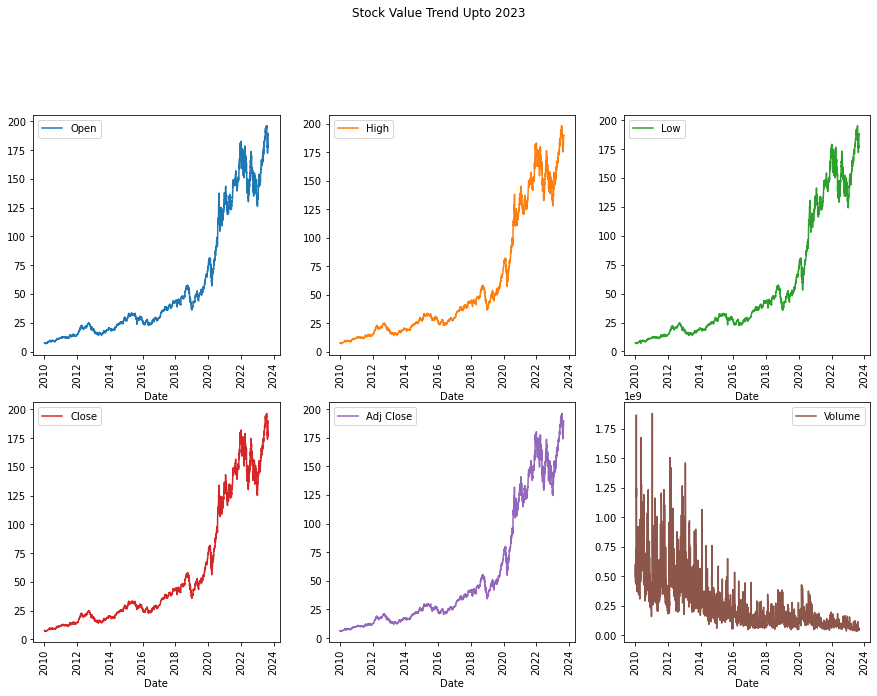

In [12]:
Column_List= ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

apple.plot(x= "Date", y = Column_List, subplots = True, layout = (3, 3), figsize = (15, 15), 
         sharex =  False, title = "Stock Value Trend Upto 2023", rot=90)

# On February 29 2020, the first death from coronavirus in the U.S. was reported at EvergreenHealth Medical Center in Kirkland, Washington

In [13]:
###Source https://en.wikipedia.org/wiki/Timeline_of_the_COVID-19_pandemic_in_the_United_States_(2020)

In [14]:
filtered_apple = apple[(apple['Date'] >= '2020-01-01') & (apple['Date'] <= '2020-04-30')]

fig = go.Figure()
fig.add_trace(go.Scatter(x=filtered_apple['Date'], y=filtered_apple['Close'], mode='lines', name='Stock Price'))

fig.update_layout(
    title='Stock Price During Covid-19 and Before Announcement',  
    xaxis=dict(
        title='Date',  
        tickangle=-45,  
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)', 
        nticks=10  
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)', 
        nticks=10
    ),
    hovermode='x',
    plot_bgcolor='black'
)
fig.show()

# Reports shared in late 2021 indicated that Apple could officially announce the car project in early 2022 and launch it by 2025.


In [15]:
#SOURCE
#https://appleinsider.com/inside/apple-car

# Lets see if that rumor helped Apple.Inc or it was just Covid-19s Lost Baggauge

In [16]:
anoucement = apple[(apple['Date'] >= '2020-04-01') & (apple['Date'] <= '2020-09-30')]

fig = go.Figure()
fig.add_trace(go.Scatter(x=anoucement['Date'], y=anoucement['Close'], mode='lines', name='Stock Price'))

fig.update_layout(
    title='Stock Price After Anoucement',
    xaxis=dict(
        title='Date',  
        tickangle=-45,  
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)', 
        nticks=10  
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)', 
        nticks=10  
    ),
    hovermode='x',
    plot_bgcolor='black'
)
fig.show()

# Similarly Tesla announced new Smartphone launch 

In [17]:
filtered_tesla = tesla[(tesla['Date'] >= '2020-01-01') & (tesla['Date'] <= '2020-04-30')]

fig = go.Figure()
fig.add_trace(go.Scatter(x=filtered_tesla['Date'], y=filtered_tesla['Close'], mode='lines', name='Stock Price'))

fig.update_layout(
    title='Stock Price During Covid-19 and Before Announcement', 
    xaxis=dict(
        title='Date',  
        tickangle=-45,  
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)', 
        nticks=10  
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)', 
        nticks=10
    ),
    hovermode='x',
    plot_bgcolor='black'
)
fig.show()

# Lets see if that rumor helped Tesla or it was just to recover losses from Covid-19s stock crash.

In [18]:
anoucement_tesla = tesla[(apple['Date'] >= '2020-04-01') & (apple['Date'] <= '2020-09-30')]

fig = go.Figure()
fig.add_trace(go.Scatter(x=anoucement_tesla['Date'], y=anoucement_tesla['Close'], mode='lines', name='Stock Price'))

fig.update_layout(
    title='Stock Price After Anoucement',
    xaxis=dict(
        title='Date',  
        tickangle=-45,  
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)', 
        nticks=10  
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='rgba(255,255,255,0.1)', 
        nticks=10  
    ),
    hovermode='x',
    plot_bgcolor='black'
)


fig.show()

# Lets find out how Apple, Samsung and Tesla stocks would have performed without covid-19(After 2020)

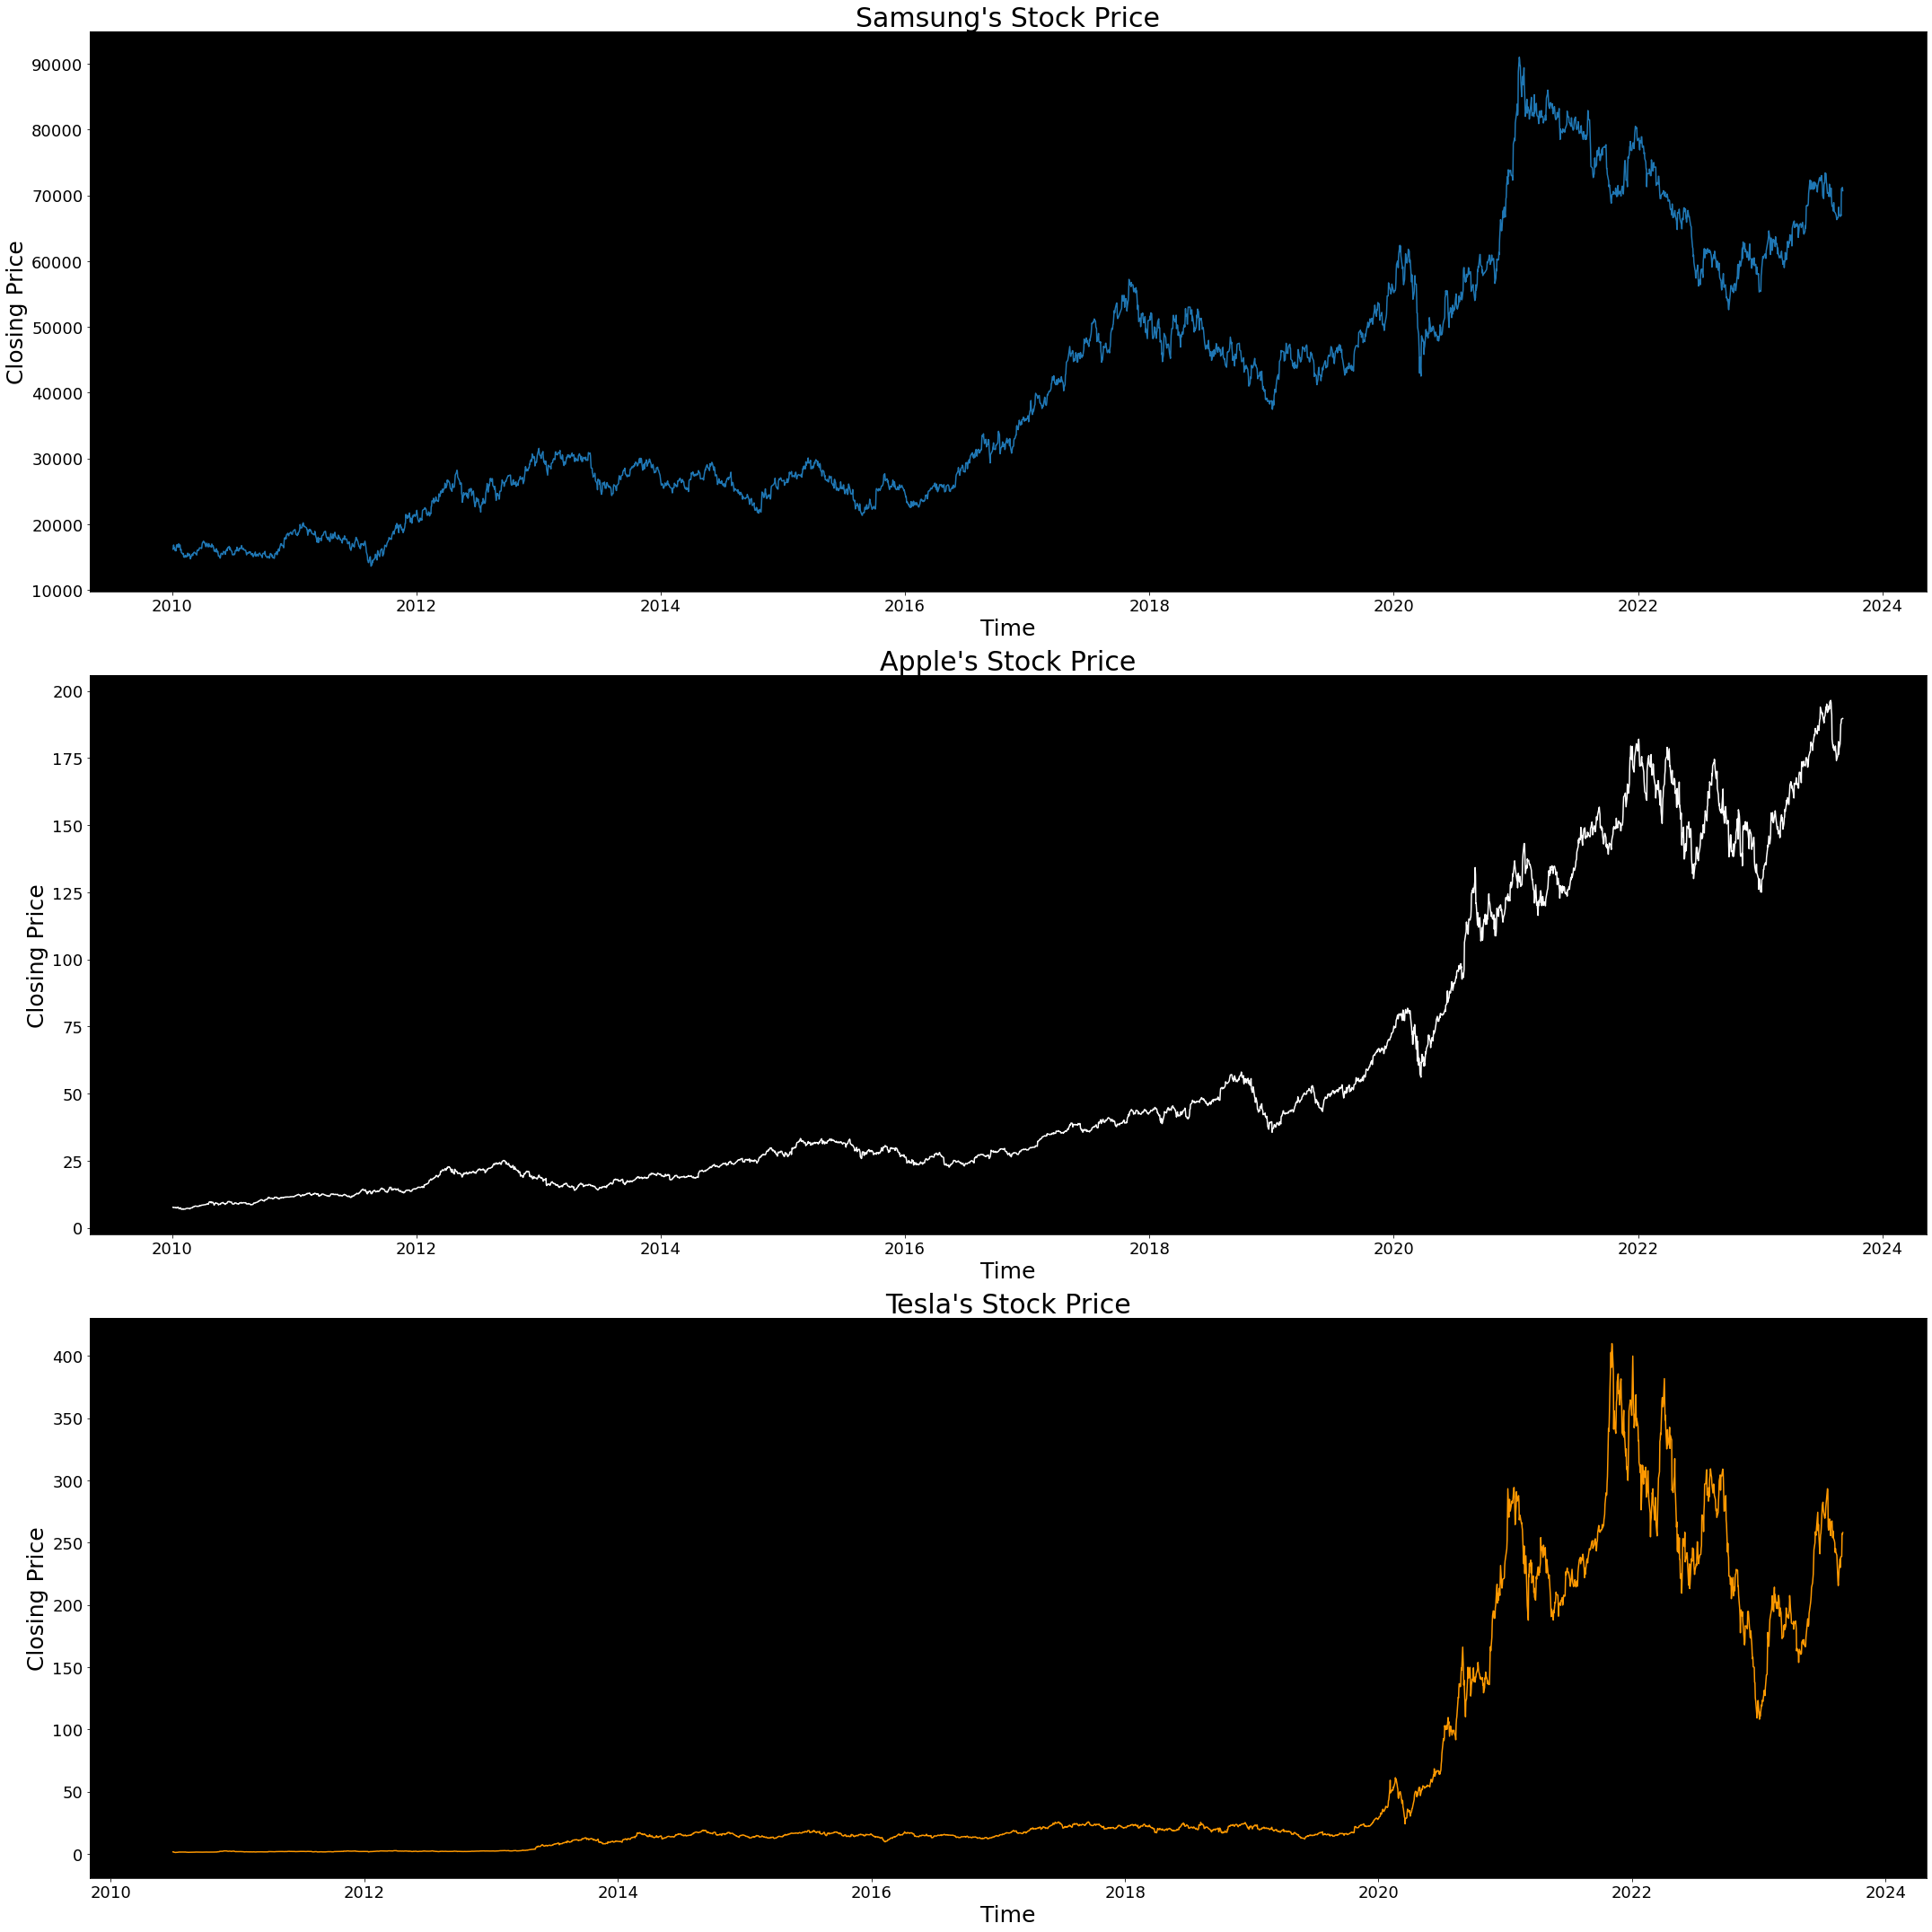

In [19]:
def visualize_faang_stock_prices(samsg, apple, tesla):

    fig, axes = plt.subplots(3, 1, figsize=(30, 30))


    axes[0].set_facecolor('black')
    axes[0].plot(samsg['Date'], samsg['Close'])
    axes[0].set_title("Samsung's Stock Price", fontsize=30)
    axes[0].set_xlabel('Time', fontsize=25)
    axes[0].set_ylabel('Closing Price', fontsize=25)
    axes[0].xaxis.set_tick_params(labelsize=18)
    axes[0].yaxis.set_tick_params(labelsize=18)
    
    axes[1].set_facecolor('black')
    axes[1].plot(apple['Date'], apple['Close'], color='white')
    axes[1].set_title("Apple's Stock Price", fontsize=30)
    axes[1].set_xlabel('Time', fontsize=25)
    axes[1].set_ylabel('Closing Price', fontsize=25)
    axes[1].xaxis.set_tick_params(labelsize=18)
    axes[1].yaxis.set_tick_params(labelsize=18)

    axes[2].set_facecolor('black')
    axes[2].plot(tesla['Date'], tesla['Close'], color='#FF9900')
    axes[2].set_title("Tesla's Stock Price", fontsize=30)
    axes[2].set_xlabel('Time', fontsize=25)
    axes[2].set_ylabel('Closing Price', fontsize=25)
    axes[2].xaxis.set_tick_params(labelsize=18)
    axes[2].yaxis.set_tick_params(labelsize=18)

    plt.tight_layout() 
    plt.show()


visualize_faang_stock_prices(samsg, apple, tesla)

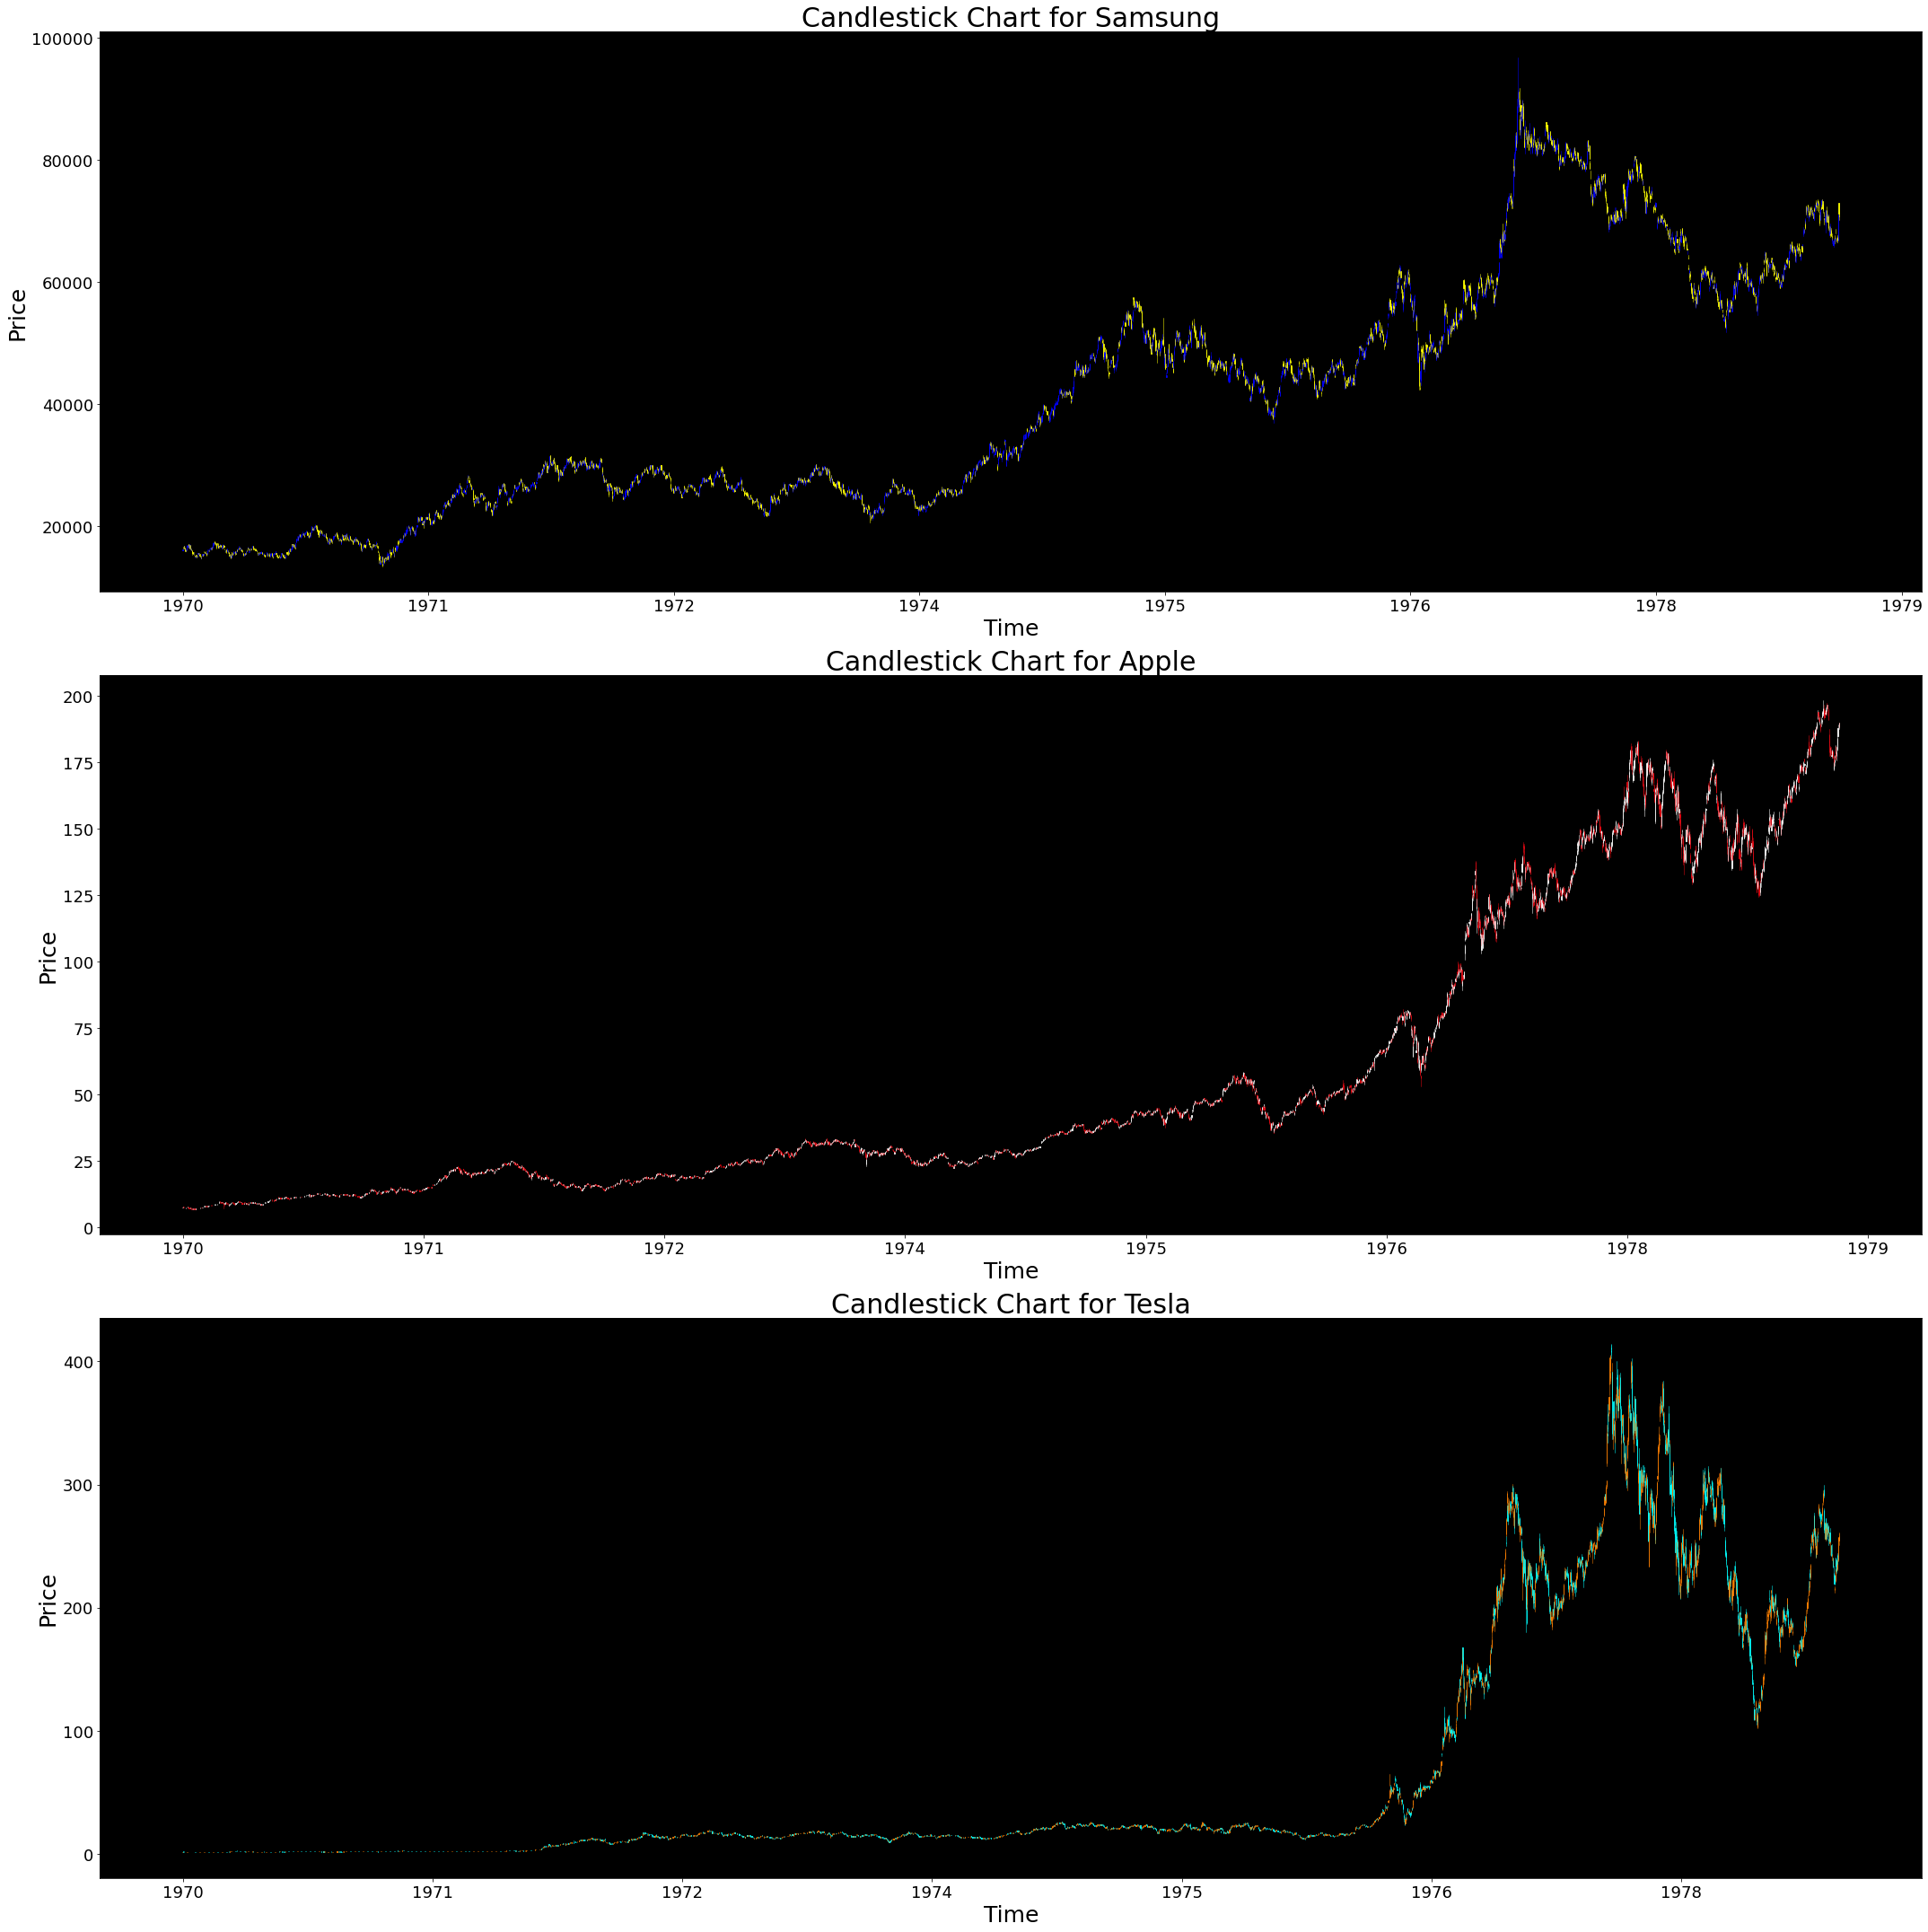

In [20]:
def visualize_faang_candlestick_charts(samsg, apple, tesla):
    candlestick_chart_data = ['Date', 'Open', 'High', 'Low', 'Close']

    new_samsg_df = samsg[candlestick_chart_data]
    new_apple_df = apple[candlestick_chart_data]
    new_tesla_df = tesla[candlestick_chart_data]

    new_samsg_df['Date'] = new_samsg_df['Date'].map(pd.to_datetime)
    new_apple_df['Date'] = new_apple_df['Date'].map(pd.to_datetime)
    new_tesla_df['Date'] = new_tesla_df['Date'].map(pd.to_datetime)

    fig, axes = plt.subplots(3, 1, figsize=(30, 30))

    date_format = DateFormatter('%Y')
    
    for ax, data, title, colorup, colordown in zip(
        axes.flatten(), 
        [new_samsg_df, new_apple_df, new_tesla_df], 
        ['Samsung', 'Apple', 'Tesla'], 
        ['#0000FF', '#FFFFFF', '#FF8000'], 
        ['#FFFF00', '#E50913', '#01FFFF']
    ):
        ax.set_facecolor('black')
        ax.xaxis.set_major_formatter(date_format)
        candlestick_ohlc(ax, zip(range(len(data)), data['Open'], data['High'], data['Low'], data['Close']), colorup=colorup, colordown=colordown, alpha=0.8)
        ax.set_title(f'Candlestick Chart for {title}', fontsize=30)
        ax.set_xlabel('Time', fontsize=25)
        ax.set_ylabel('Price', fontsize=25)
        ax.xaxis.set_tick_params(labelsize=18)
        ax.yaxis.set_tick_params(labelsize=18)

    plt.tight_layout()
    plt.show()

visualize_faang_candlestick_charts(samsg, apple, tesla)


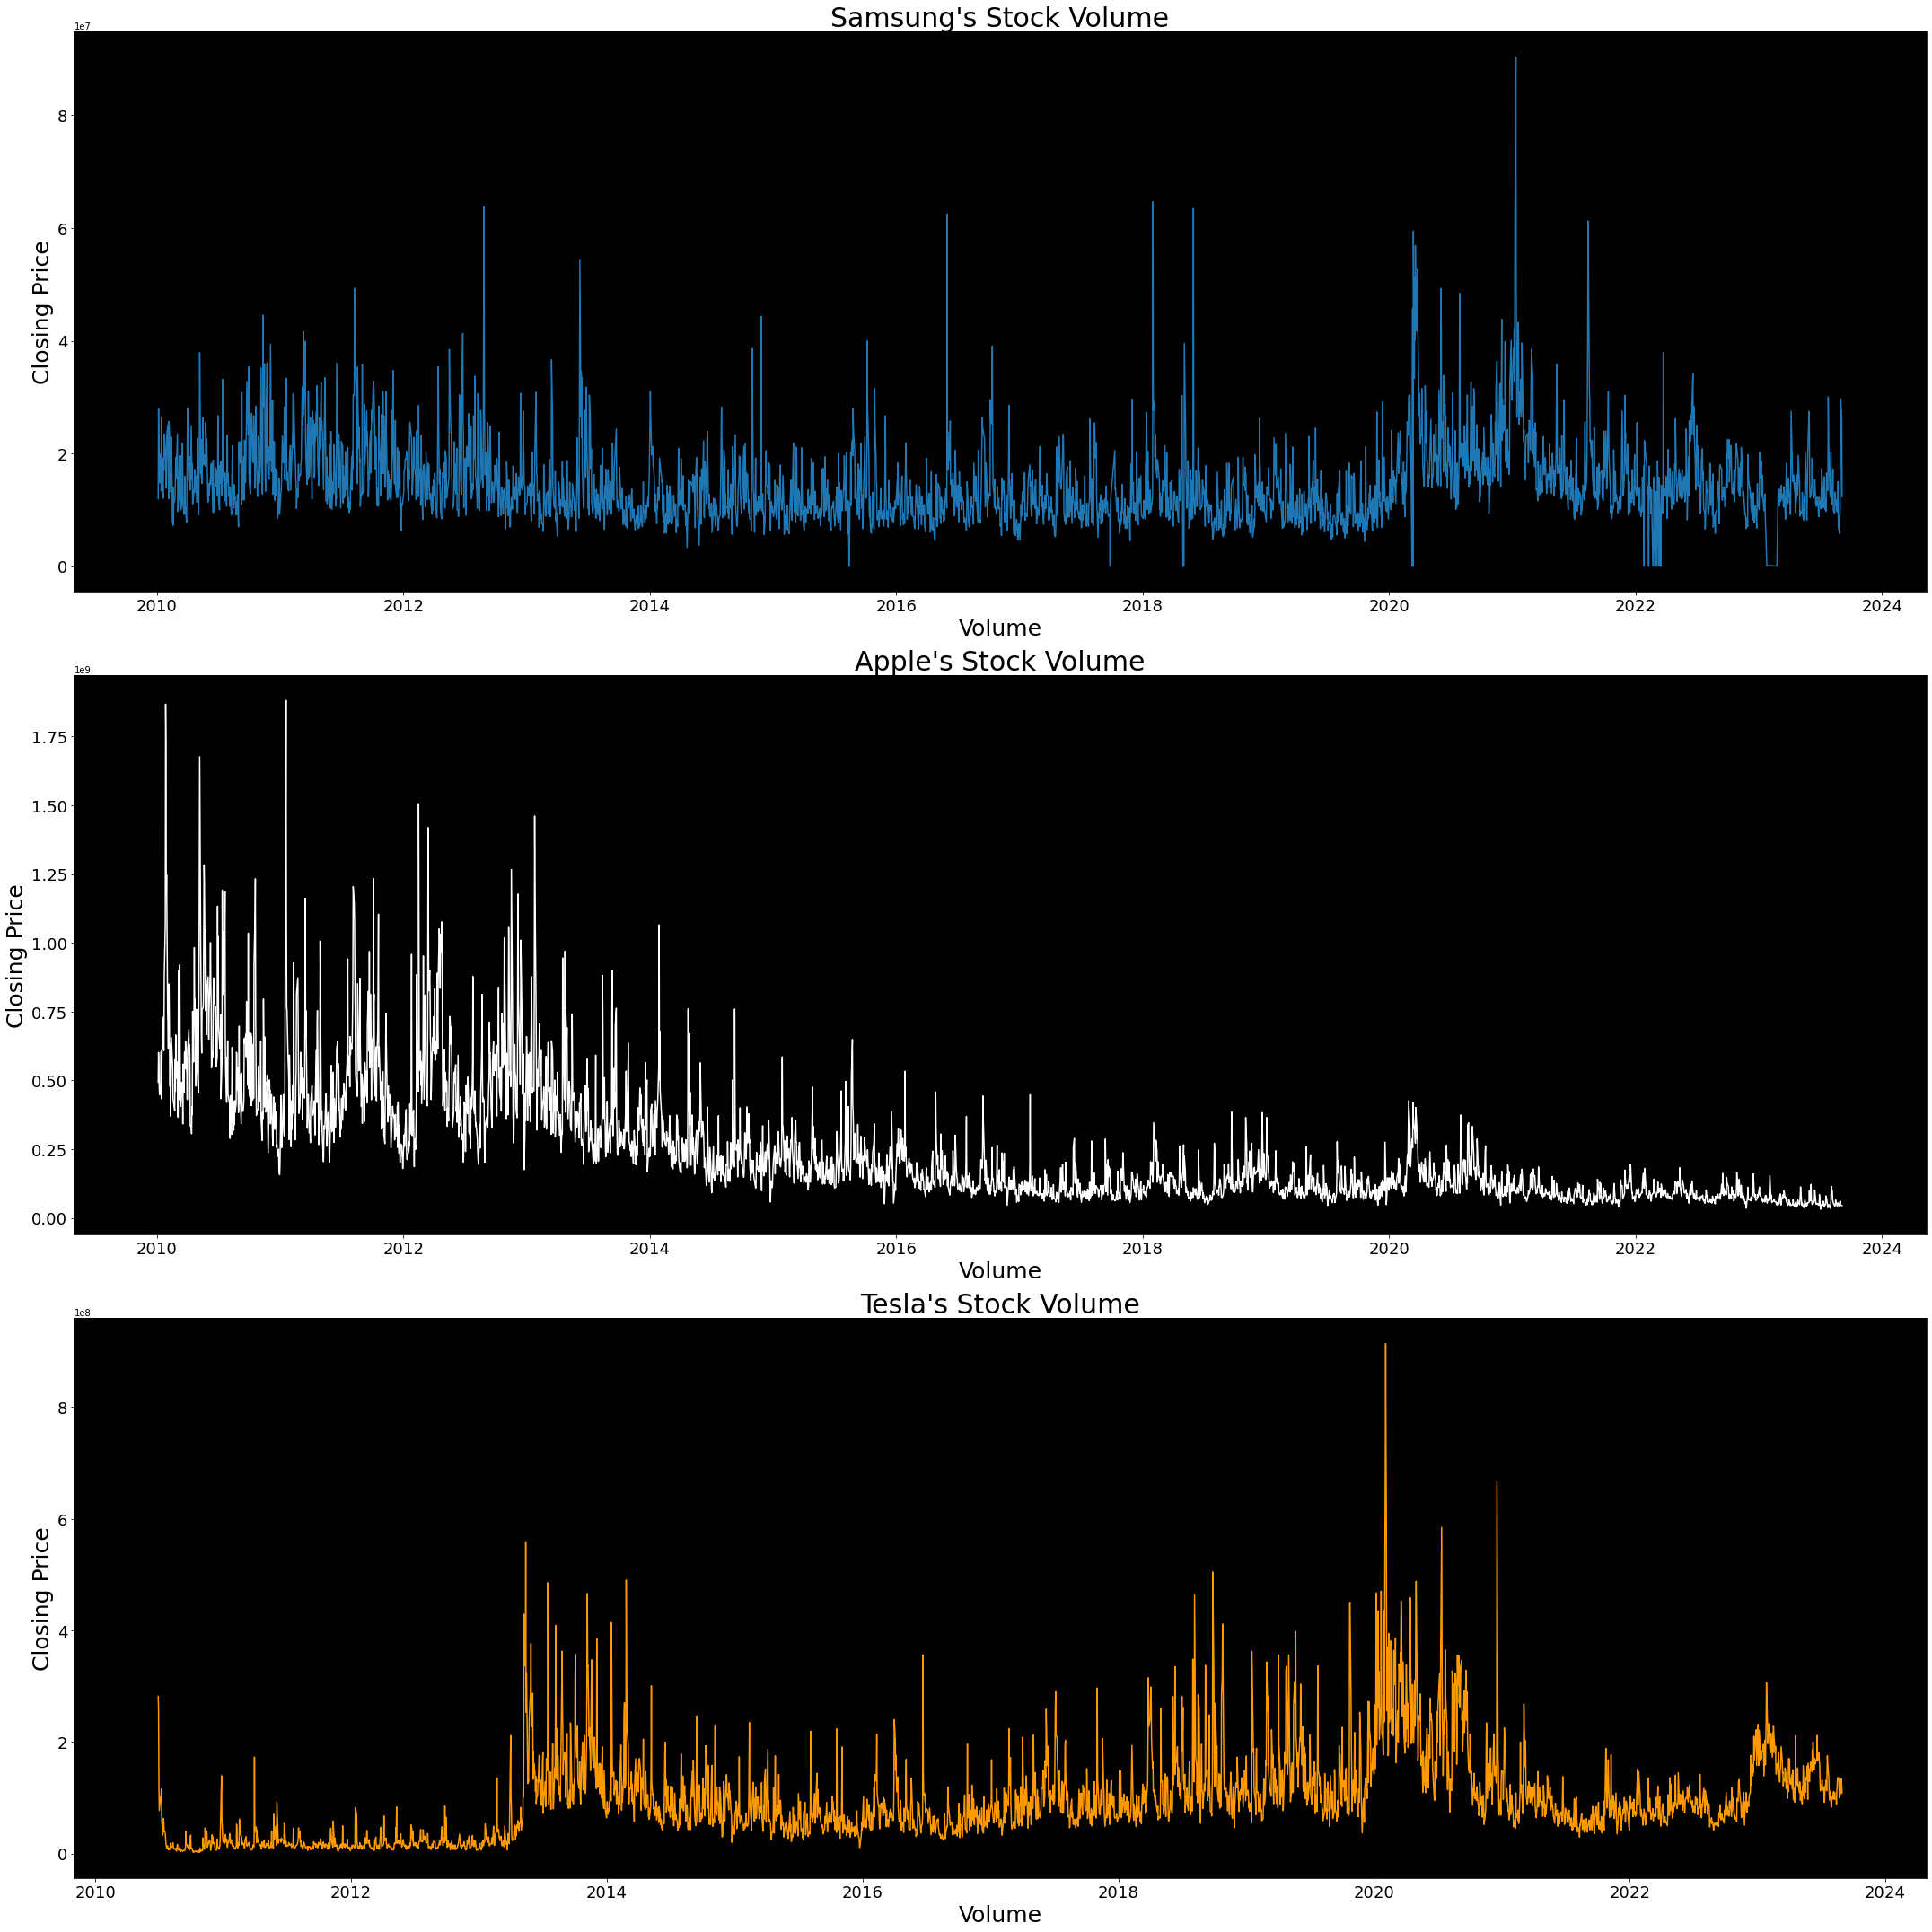

In [21]:
def visualize_faang_stock_volume(samsg, apple, tesla):
    fig, axes = plt.subplots(3, 1, figsize=(30, 30))


    axes[0].set_facecolor('black')
    axes[0].plot(samsg['Date'], samsg['Volume'])
    axes[0].set_title("Samsung's Stock Volume", fontsize=30)
    axes[0].set_xlabel('Volume', fontsize=25)
    axes[0].set_ylabel('Closing Price', fontsize=25)
    axes[0].xaxis.set_tick_params(labelsize=18)
    axes[0].yaxis.set_tick_params(labelsize=18)
    
    axes[1].set_facecolor('black')
    axes[1].plot(apple['Date'], apple['Volume'], color='white')
    axes[1].set_title("Apple's Stock Volume", fontsize=30)
    axes[1].set_xlabel('Volume', fontsize=25)
    axes[1].set_ylabel('Closing Price', fontsize=25)
    axes[1].xaxis.set_tick_params(labelsize=18)
    axes[1].yaxis.set_tick_params(labelsize=18)

    axes[2].set_facecolor('black')
    axes[2].plot(tesla['Date'], tesla['Volume'], color='#FF9900')
    axes[2].set_title("Tesla's Stock Volume", fontsize=30)
    axes[2].set_xlabel('Volume', fontsize=25)
    axes[2].set_ylabel('Closing Price', fontsize=25)
    axes[2].xaxis.set_tick_params(labelsize=18)
    axes[2].yaxis.set_tick_params(labelsize=18)

    plt.tight_layout() 
    plt.show()
visualize_faang_stock_volume(samsg, apple, tesla)

In [22]:
candlestick_chart_data = ['Date', 'Open', 'High', 'Low', 'Close']

new_samsg_df = samsg[candlestick_chart_data]
new_apple_df = apple[candlestick_chart_data]
new_tesla_df = tesla[candlestick_chart_data]

def create_moving_averages_columns(company_data):
    days_for_moving_averages = [10, 50, 100]
    
    for moving_averages in days_for_moving_averages:
        column = f'MA for {moving_averages} days'
        company_data[column] = company_data['Close'].rolling(moving_averages).mean()
        
    return company_data

new_samsg_df = create_moving_averages_columns(new_samsg_df)
new_apple_df = create_moving_averages_columns(new_apple_df)
new_tesla_df = create_moving_averages_columns(new_tesla_df)


new_tesla_df.tail(10)

Date        Open        High         Low       Close  \
3307 2023-08-18  214.119995  217.580002  212.360001  215.490005   
3308 2023-08-21  221.550003  232.130005  220.580002  231.279999   
3309 2023-08-22  240.250000  240.820007  229.550003  233.190002   
3310 2023-08-23  229.339996  238.979996  229.289993  236.860001   
3311 2023-08-24  238.660004  238.919998  228.179993  230.039993   
3312 2023-08-25  231.309998  239.000000  230.350006  238.589996   
3313 2023-08-28  242.580002  244.380005  235.350006  238.820007   
3314 2023-08-29  238.580002  257.480011  237.770004  257.179993   
3315 2023-08-30  254.199997  260.510010  250.589996  256.899994   
3316 2023-08-31  255.979996  261.179993  255.050003  258.079987   

      MA for 10 days  MA for 50 days  MA for 100 days  
3307      236.436000      258.915000       220.462700  
3308      234.419000      258.843400       220.883600  
3309      232.768001      258.619200       221.276700  
3310      232.235001      258.359800       221.692500  
3311      230.705000      257.786400       221.918300  
3312      230.299001      257.422400       222.356499  
3313      230.205002      257.080800       222.818900  
3314      232.627000      257.013600       223.535499  
3315      235.756999      256.662599       224.253899  
3316      239.642998      256.634999       224.989599

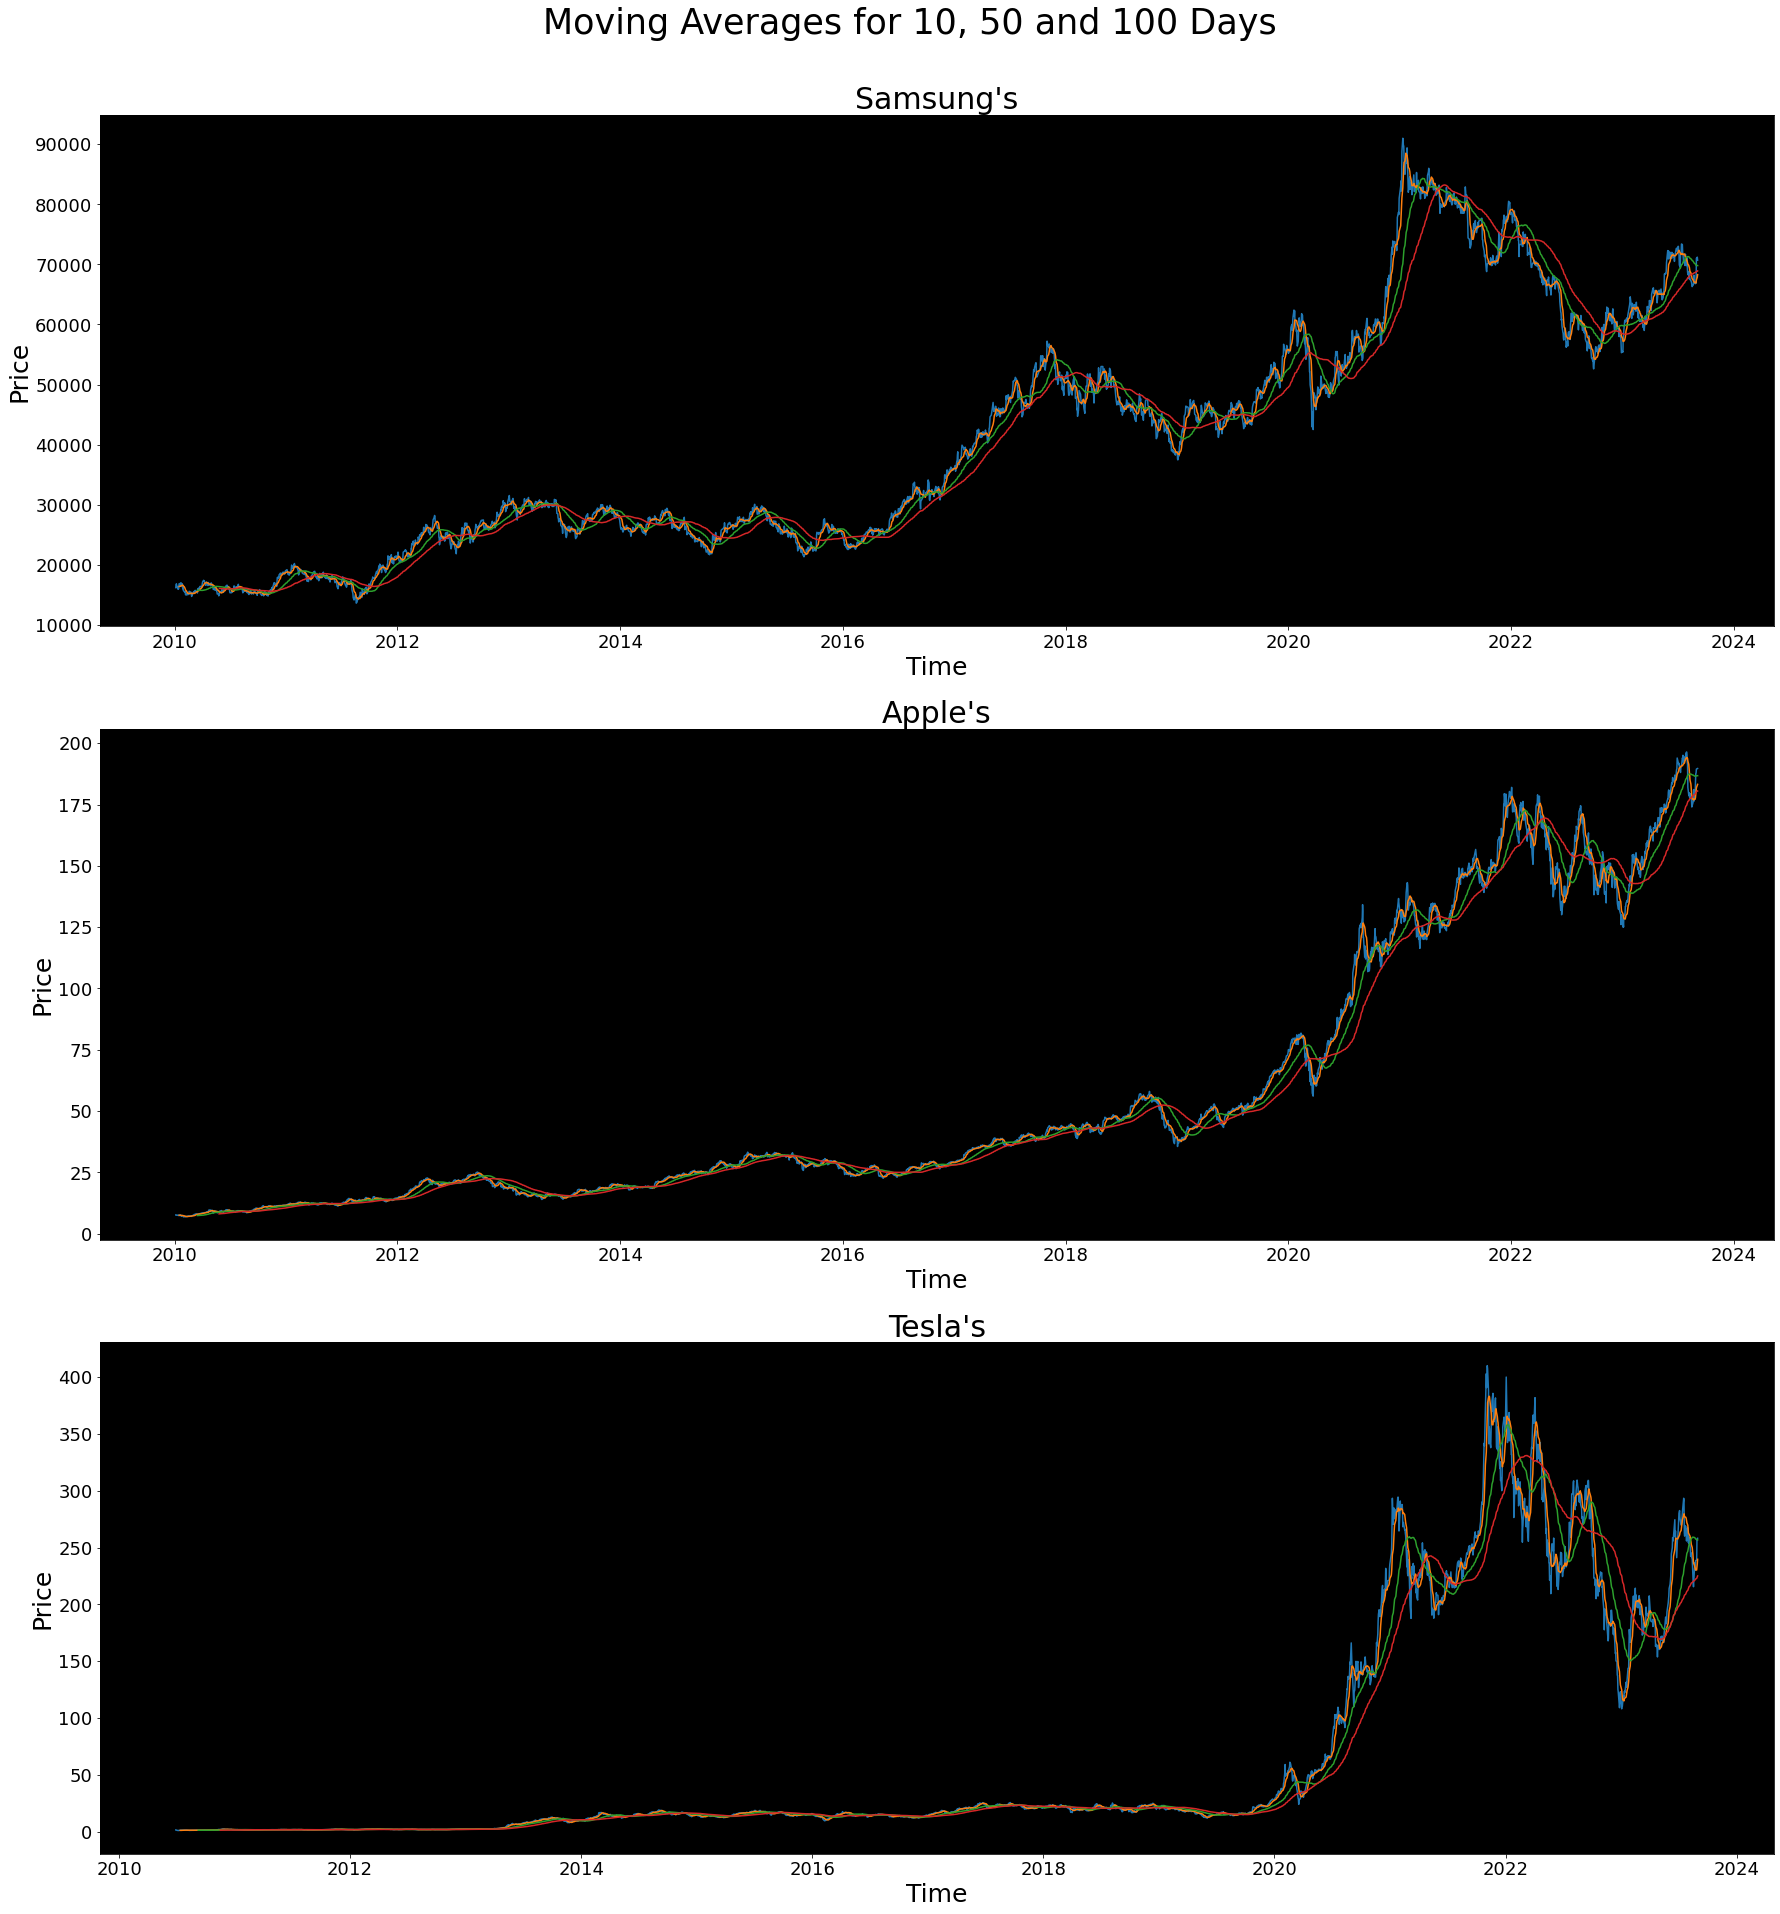

In [23]:
def visualize_moving_averages(new_samsg_df, new_apple_df, new_tesla_df,time, feature, ma1, ma2, ma3):
    
    fig, axes = plt.subplots(3, 1, figsize=(30, 30))
    plt.suptitle('Moving Averages for 10, 50 and 100 Days', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 35)
    
    axes[0].set_facecolor('black')
    axes[0].plot(new_samsg_df[time], new_samsg_df[feature], label = feature)
    axes[0].plot(new_samsg_df[time], new_samsg_df[ma1], label = ma1)
    axes[0].plot(new_samsg_df[time], new_samsg_df[ma2], label = ma2)
    axes[0].plot(new_samsg_df[time], new_samsg_df[ma3], label = ma3)
    axes[0].set_title("Samsung's", fontsize=30)
    axes[0].set_xlabel('Time', fontsize=25)
    axes[0].set_ylabel('Price', fontsize=25)
    axes[0].xaxis.set_tick_params(labelsize=18)
    axes[0].yaxis.set_tick_params(labelsize=18)
    
    axes[1].set_facecolor('black')
    axes[1].plot(new_apple_df[time], new_apple_df[feature], label = feature)
    axes[1].plot(new_apple_df[time], new_apple_df[ma1], label = ma1)
    axes[1].plot(new_apple_df[time], new_apple_df[ma2], label = ma2)
    axes[1].plot(new_apple_df[time], new_apple_df[ma3], label = ma3)
    axes[1].set_title("Apple's", fontsize=30)
    axes[1].set_xlabel('Time', fontsize=25)
    axes[1].set_ylabel('Price', fontsize=25)
    axes[1].xaxis.set_tick_params(labelsize=18)
    axes[1].yaxis.set_tick_params(labelsize=18)
    
    axes[2].set_facecolor('black')
    axes[2].plot(new_tesla_df[time], new_tesla_df[feature], label = feature)
    axes[2].plot(new_tesla_df[time], new_tesla_df[ma1], label = ma1)
    axes[2].plot(new_tesla_df[time], new_tesla_df[ma2], label = ma2)
    axes[2].plot(new_tesla_df[time], new_tesla_df[ma3], label = ma3)
    axes[2].set_title("Tesla's", fontsize=30)
    axes[2].set_xlabel('Time', fontsize=25)
    axes[2].set_ylabel('Price', fontsize=25)
    axes[2].xaxis.set_tick_params(labelsize=18)
    axes[2].yaxis.set_tick_params(labelsize=18)
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
visualize_moving_averages(new_samsg_df, new_apple_df, new_tesla_df,'Date', 'Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days')

# Daily Retruns of Stocks

In [24]:
new_samsg_df['Daily Return'] = new_samsg_df['Close'].pct_change()
new_apple_df['Daily Return'] = new_apple_df['Close'].pct_change()
new_tesla_df['Daily Return'] = new_tesla_df['Close'].pct_change()

new_tesla_df.tail()

Date        Open        High         Low       Close  \
3312 2023-08-25  231.309998  239.000000  230.350006  238.589996   
3313 2023-08-28  242.580002  244.380005  235.350006  238.820007   
3314 2023-08-29  238.580002  257.480011  237.770004  257.179993   
3315 2023-08-30  254.199997  260.510010  250.589996  256.899994   
3316 2023-08-31  255.979996  261.179993  255.050003  258.079987   

      MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
3312      230.299001      257.422400       222.356499      0.037167  
3313      230.205002      257.080800       222.818900      0.000964  
3314      232.627000      257.013600       223.535499      0.076878  
3315      235.756999      256.662599       224.253899     -0.001089  
3316      239.642998      256.634999       224.989599      0.004593

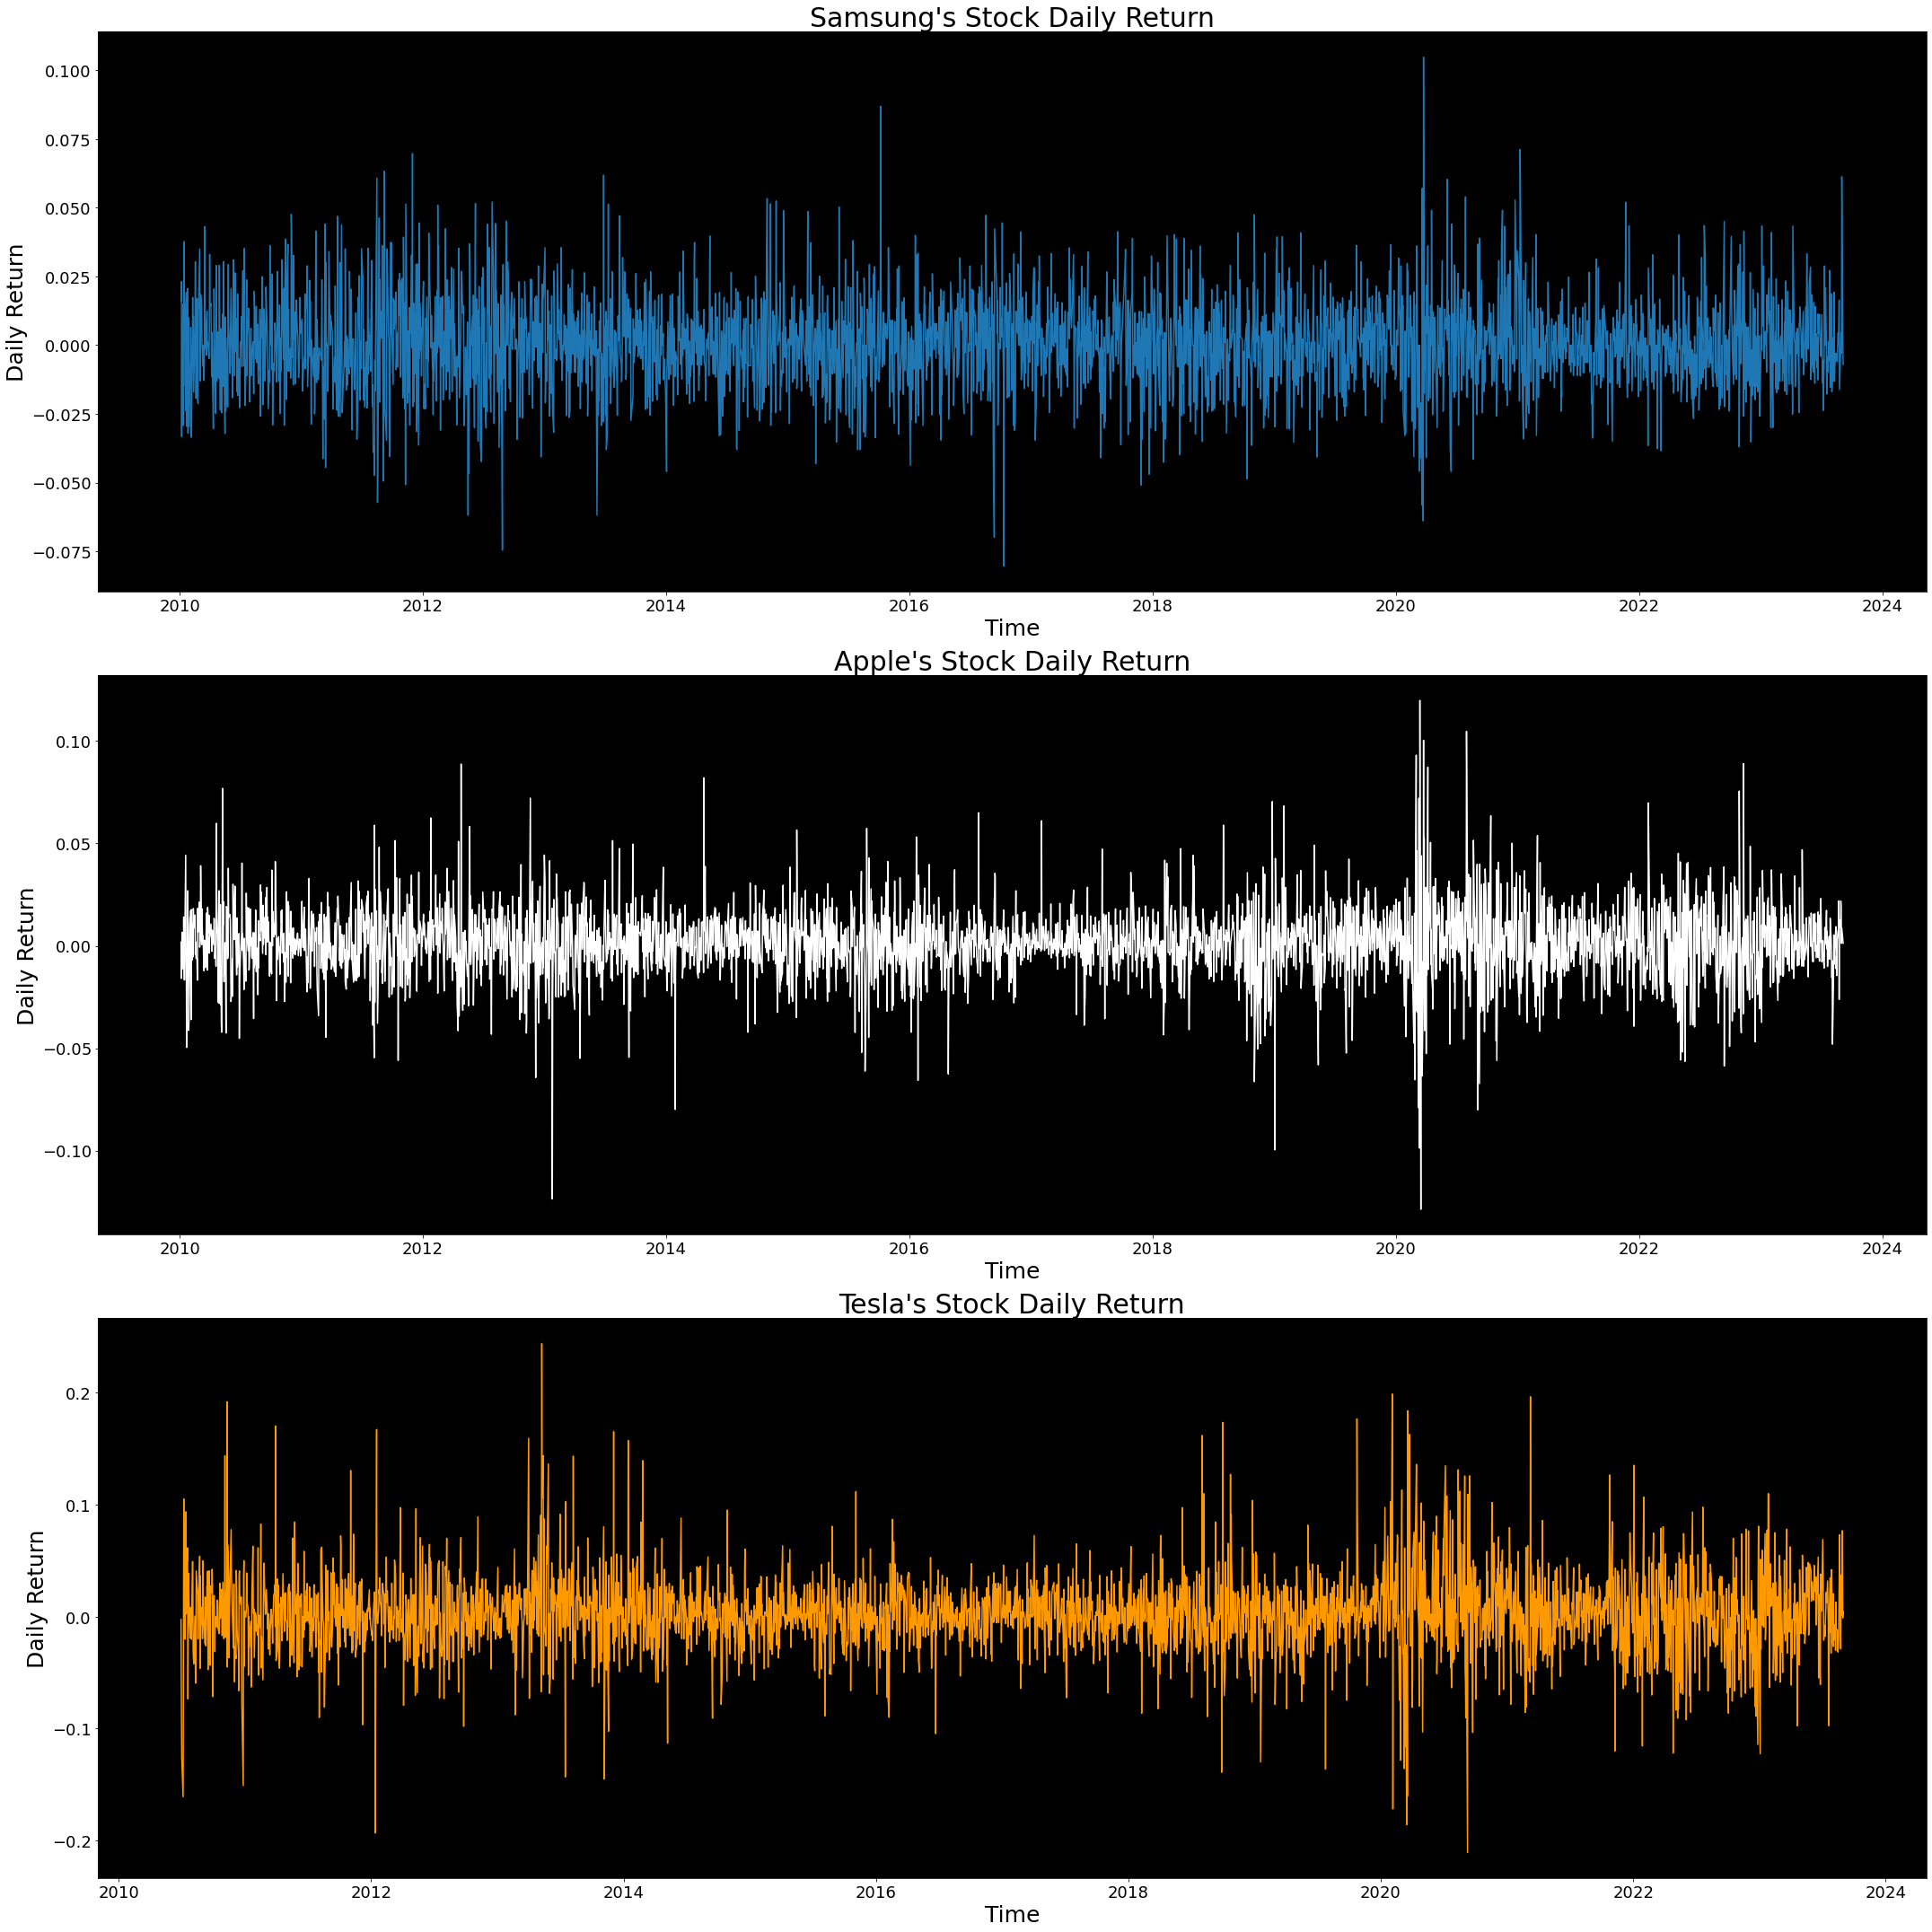

In [25]:
def visualize_faang_daily_return(samsg, apple, tesla):
    fig, axes = plt.subplots(3, 1, figsize=(30, 30))
    
    
    axes[0].set_facecolor('black')
    axes[0].plot(samsg['Date'], samsg['Daily Return'])
    axes[0].set_title("Samsung's Stock Daily Return", fontsize=30)
    axes[0].set_xlabel('Time', fontsize=25)
    axes[0].set_ylabel('Daily Return', fontsize=25)
    axes[0].xaxis.set_tick_params(labelsize=18)
    axes[0].yaxis.set_tick_params(labelsize=18)
    
    axes[1].set_facecolor('black')
    axes[1].plot(apple['Date'], apple['Daily Return'], color='white')
    axes[1].set_title("Apple's Stock Daily Return", fontsize=30)
    axes[1].set_xlabel('Time', fontsize=25)
    axes[1].set_ylabel('Daily Return', fontsize=25)
    axes[1].xaxis.set_tick_params(labelsize=18)
    axes[1].yaxis.set_tick_params(labelsize=18)

    axes[2].set_facecolor('black')
    axes[2].plot(tesla['Date'], tesla['Daily Return'], color='#FF9900')
    axes[2].set_title("Tesla's Stock Daily Return", fontsize=30)
    axes[2].set_xlabel('Time', fontsize=25)
    axes[2].set_ylabel('Daily Return', fontsize=25)
    axes[2].xaxis.set_tick_params(labelsize=18)
    axes[2].yaxis.set_tick_params(labelsize=18)

    plt.tight_layout() 
    plt.show()
visualize_faang_daily_return(new_samsg_df, new_apple_df, new_tesla_df)

In [26]:
def retrieve_closing_prices_only(data):
    data = data[['Close']]
    return data

def min_max_scaling(data):
    scaler = MinMaxScaler(feature_range = (0, 1))
    data = scaler.fit_transform(data.values)
    return scaler, data
    
samsg_scaler, new_samsg_df = min_max_scaling(retrieve_closing_prices_only(new_samsg_df))
apple_scaler, new_apple_df = min_max_scaling(retrieve_closing_prices_only(new_apple_df))
tesla_scaler, new_tesla_df = min_max_scaling(retrieve_closing_prices_only(new_tesla_df))

new_samsg_df

array([[0.03333333],
       [0.03669251],
       [0.04160207],
       ...,
       [0.74160207],
       [0.74418605],
       [0.7377261 ]])

In [39]:
def split_and_reshape_data(dataframe, pred_days, company):
    prediction_days = pred_days
    
    train_size = int(np.ceil(len(dataframe) * 0.75))
    test_size = len(dataframe) - train_size
    print(f'The training size for {company.title()} is {train_size} rows')
    print(f'The testing size for {company.title()} is {test_size} rows')
    
    train_data = dataframe[0: int(train_size), :]
    test_data = dataframe[train_size - prediction_days:, :]
    
    X_train, y_train, X_test, y_test = [], [], [], []
    
    for i in range(prediction_days, len(train_data)):
        X_train.append(train_data[i - prediction_days: i, 0])
        y_train.append(train_data[i, 0])
        
    for i in range(prediction_days, len(test_data)):
        X_test.append(test_data[i - prediction_days: i, 0])
        y_test.append(test_data[i, 0])
        
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
        
    print('Data for {} split successfully'.format(company.title()))
    
    return X_train, y_train, X_test, y_test
    
X_train_samsg, y_train_samsg, X_test_samsg, y_test_samsg = split_and_reshape_data(new_samsg_df, 30, 'SAMSUNG')
X_train_apple, y_train_apple, X_test_apple, y_test_apple = split_and_reshape_data(new_apple_df, 30, 'APPLE')
X_train_tesla, y_train_tesla, X_test_tesla, y_test_tesla = split_and_reshape_data(new_tesla_df, 30, 'TESLA')

The training size for Samsung is 2531 rows
The testing size for Samsung is 843 rows
Data for Samsung split successfully
The training size for Apple is 2581 rows
The testing size for Apple is 860 rows
Data for Apple split successfully
The training size for Tesla is 2488 rows
The testing size for Tesla is 829 rows
Data for Tesla split successfully


In [40]:
def create_and_train_bilstm_model(X_train, y_train, X_test, y_test, company):
    
    print('=========For {}========='.format(company))
    
    model = Sequential([
    Conv1D(32, 3, strides = 1, activation = 'relu', input_shape = [30, 1]),
    Bidirectional(LSTM(64, return_sequences = True)),
    Bidirectional(LSTM(64, return_sequences = True)),
    Bidirectional(LSTM(64)),
    Dense(32, activation = 'relu'),
    Dense(1)
    ])
    
    model.compile(optimizer = Adam(), loss = Huber(), metrics = ['mse', 'mae'])
    
    predictor = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50)
    
    y_pred = model.predict(X_test)
    
    return model, predictor, y_pred

samsg_model, samsg_predictor, samsg_y_pred = create_and_train_bilstm_model(X_train_samsg, y_train_samsg, X_test_samsg, y_test_samsg, 'SAMSUNG')
apple_model, apple_predictor, apple_y_pred = create_and_train_bilstm_model(X_train_apple, y_train_apple, X_test_apple, y_test_apple, 'APPLE')
tesla_model, tesla_predictor, tesla_y_pred = create_and_train_bilstm_model(X_train_tesla, y_train_tesla, X_test_tesla, y_test_tesla, 'TESLA')

=========For SAMSUNG=========
Epoch 1/50
79/79 [==============================] - 11s 50ms/step - loss: 0.0021 - mse: 0.0041 - mae: 0.0348 - val_loss: 8.4981e-04 - val_mse: 0.0017 - val_mae: 0.0311
Epoch 2/50
79/79 [==============================] - 2s 31ms/step - loss: 2.4794e-04 - mse: 4.9587e-04 - mae: 0.0163 - val_loss: 0.0012 - val_mse: 0.0024 - val_mae: 0.0368
Epoch 3/50
79/79 [==============================] - 2s 31ms/step - loss: 1.9384e-04 - mse: 3.8768e-04 - mae: 0.0145 - val_loss: 8.8108e-04 - val_mse: 0.0018 - val_mae: 0.0316
Epoch 4/50
79/79 [==============================] - 3s 32ms/step - loss: 1.6946e-04 - mse: 3.3891e-04 - mae: 0.0134 - val_loss: 0.0028 - val_mse: 0.0056 - val_mae: 0.0626
Epoch 5/50
79/79 [==============================] - 3s 32ms/step - loss: 1.4786e-04 - mse: 2.9571e-04 - mae: 0.0125 - val_loss: 0.0012 - val_mse: 0.0025 - val_mae: 0.0381
Epoch 6/50
79/79 [==============================] - 3s 32ms/step - loss: 1.2980e-04 - mse: 2.5959e-04 - mae: 0.011

79/79 [==============================] - 3s 36ms/step - loss: 3.6751e-05 - mse: 7.3502e-05 - mae: 0.0063 - val_loss: 1.6933e-04 - val_mse: 3.3866e-04 - val_mae: 0.0139
Epoch 48/50
79/79 [==============================] - 3s 36ms/step - loss: 3.7329e-05 - mse: 7.4659e-05 - mae: 0.0063 - val_loss: 2.4468e-04 - val_mse: 4.8935e-04 - val_mae: 0.0166
Epoch 49/50
79/79 [==============================] - 3s 36ms/step - loss: 3.9662e-05 - mse: 7.9325e-05 - mae: 0.0066 - val_loss: 6.8267e-04 - val_mse: 0.0014 - val_mae: 0.0312
Epoch 50/50
27/27 [==============================] - 3s 12ms/step
=========For APPLE=========
Epoch 1/50
80/80 [==============================] - 14s 59ms/step - loss: 4.5247e-04 - mse: 9.0493e-04 - mae: 0.0166 - val_loss: 0.0030 - val_mse: 0.0060 - val_mae: 0.0662
Epoch 2/50
80/80 [==============================] - 3s 36ms/step - loss: 5.5173e-05 - mse: 1.1035e-04 - mae: 0.0072 - val_loss: 0.0027 - val_mse: 0.0054 - val_mae: 0.0632
Epoch 3/50
80/80 [=====================

80/80 [==============================] - 3s 35ms/step - loss: 1.0611e-05 - mse: 2.1221e-05 - mae: 0.0033 - val_loss: 7.8017e-04 - val_mse: 0.0016 - val_mae: 0.0321
Epoch 44/50
80/80 [==============================] - 3s 34ms/step - loss: 9.6370e-06 - mse: 1.9274e-05 - mae: 0.0030 - val_loss: 4.2506e-04 - val_mse: 8.5011e-04 - val_mae: 0.0227
Epoch 45/50
80/80 [==============================] - 3s 35ms/step - loss: 1.0054e-05 - mse: 2.0109e-05 - mae: 0.0032 - val_loss: 2.6657e-04 - val_mse: 5.3314e-04 - val_mae: 0.0178
Epoch 46/50
80/80 [==============================] - 3s 36ms/step - loss: 1.2254e-05 - mse: 2.4507e-05 - mae: 0.0036 - val_loss: 9.4077e-04 - val_mse: 0.0019 - val_mae: 0.0357
Epoch 47/50
80/80 [==============================] - 3s 37ms/step - loss: 1.2653e-05 - mse: 2.5306e-05 - mae: 0.0035 - val_loss: 8.3477e-04 - val_mse: 0.0017 - val_mae: 0.0341
Epoch 48/50
80/80 [==============================] - 3s 36ms/step - loss: 1.1344e-05 - mse: 2.2688e-05 - mae: 0.0033 - val_l

77/77 [==============================] - 3s 39ms/step - loss: 2.2248e-06 - mse: 4.4497e-06 - mae: 0.0013 - val_loss: 0.0085 - val_mse: 0.0170 - val_mae: 0.1085
Epoch 41/50
77/77 [==============================] - 3s 39ms/step - loss: 3.0286e-06 - mse: 6.0571e-06 - mae: 0.0017 - val_loss: 0.0157 - val_mse: 0.0313 - val_mae: 0.1555
Epoch 42/50
77/77 [==============================] - 3s 39ms/step - loss: 3.2351e-06 - mse: 6.4703e-06 - mae: 0.0017 - val_loss: 0.0102 - val_mse: 0.0204 - val_mae: 0.1208
Epoch 43/50
77/77 [==============================] - 3s 39ms/step - loss: 2.8895e-06 - mse: 5.7789e-06 - mae: 0.0016 - val_loss: 0.0135 - val_mse: 0.0271 - val_mae: 0.1432
Epoch 44/50
77/77 [==============================] - 3s 39ms/step - loss: 5.0354e-05 - mse: 1.0071e-04 - mae: 0.0056 - val_loss: 0.0114 - val_mse: 0.0227 - val_mae: 0.1245
Epoch 45/50
77/77 [==============================] - 3s 39ms/step - loss: 5.3790e-06 - mse: 1.0758e-05 - mae: 0.0022 - val_loss: 0.0158 - val_mse: 0.031

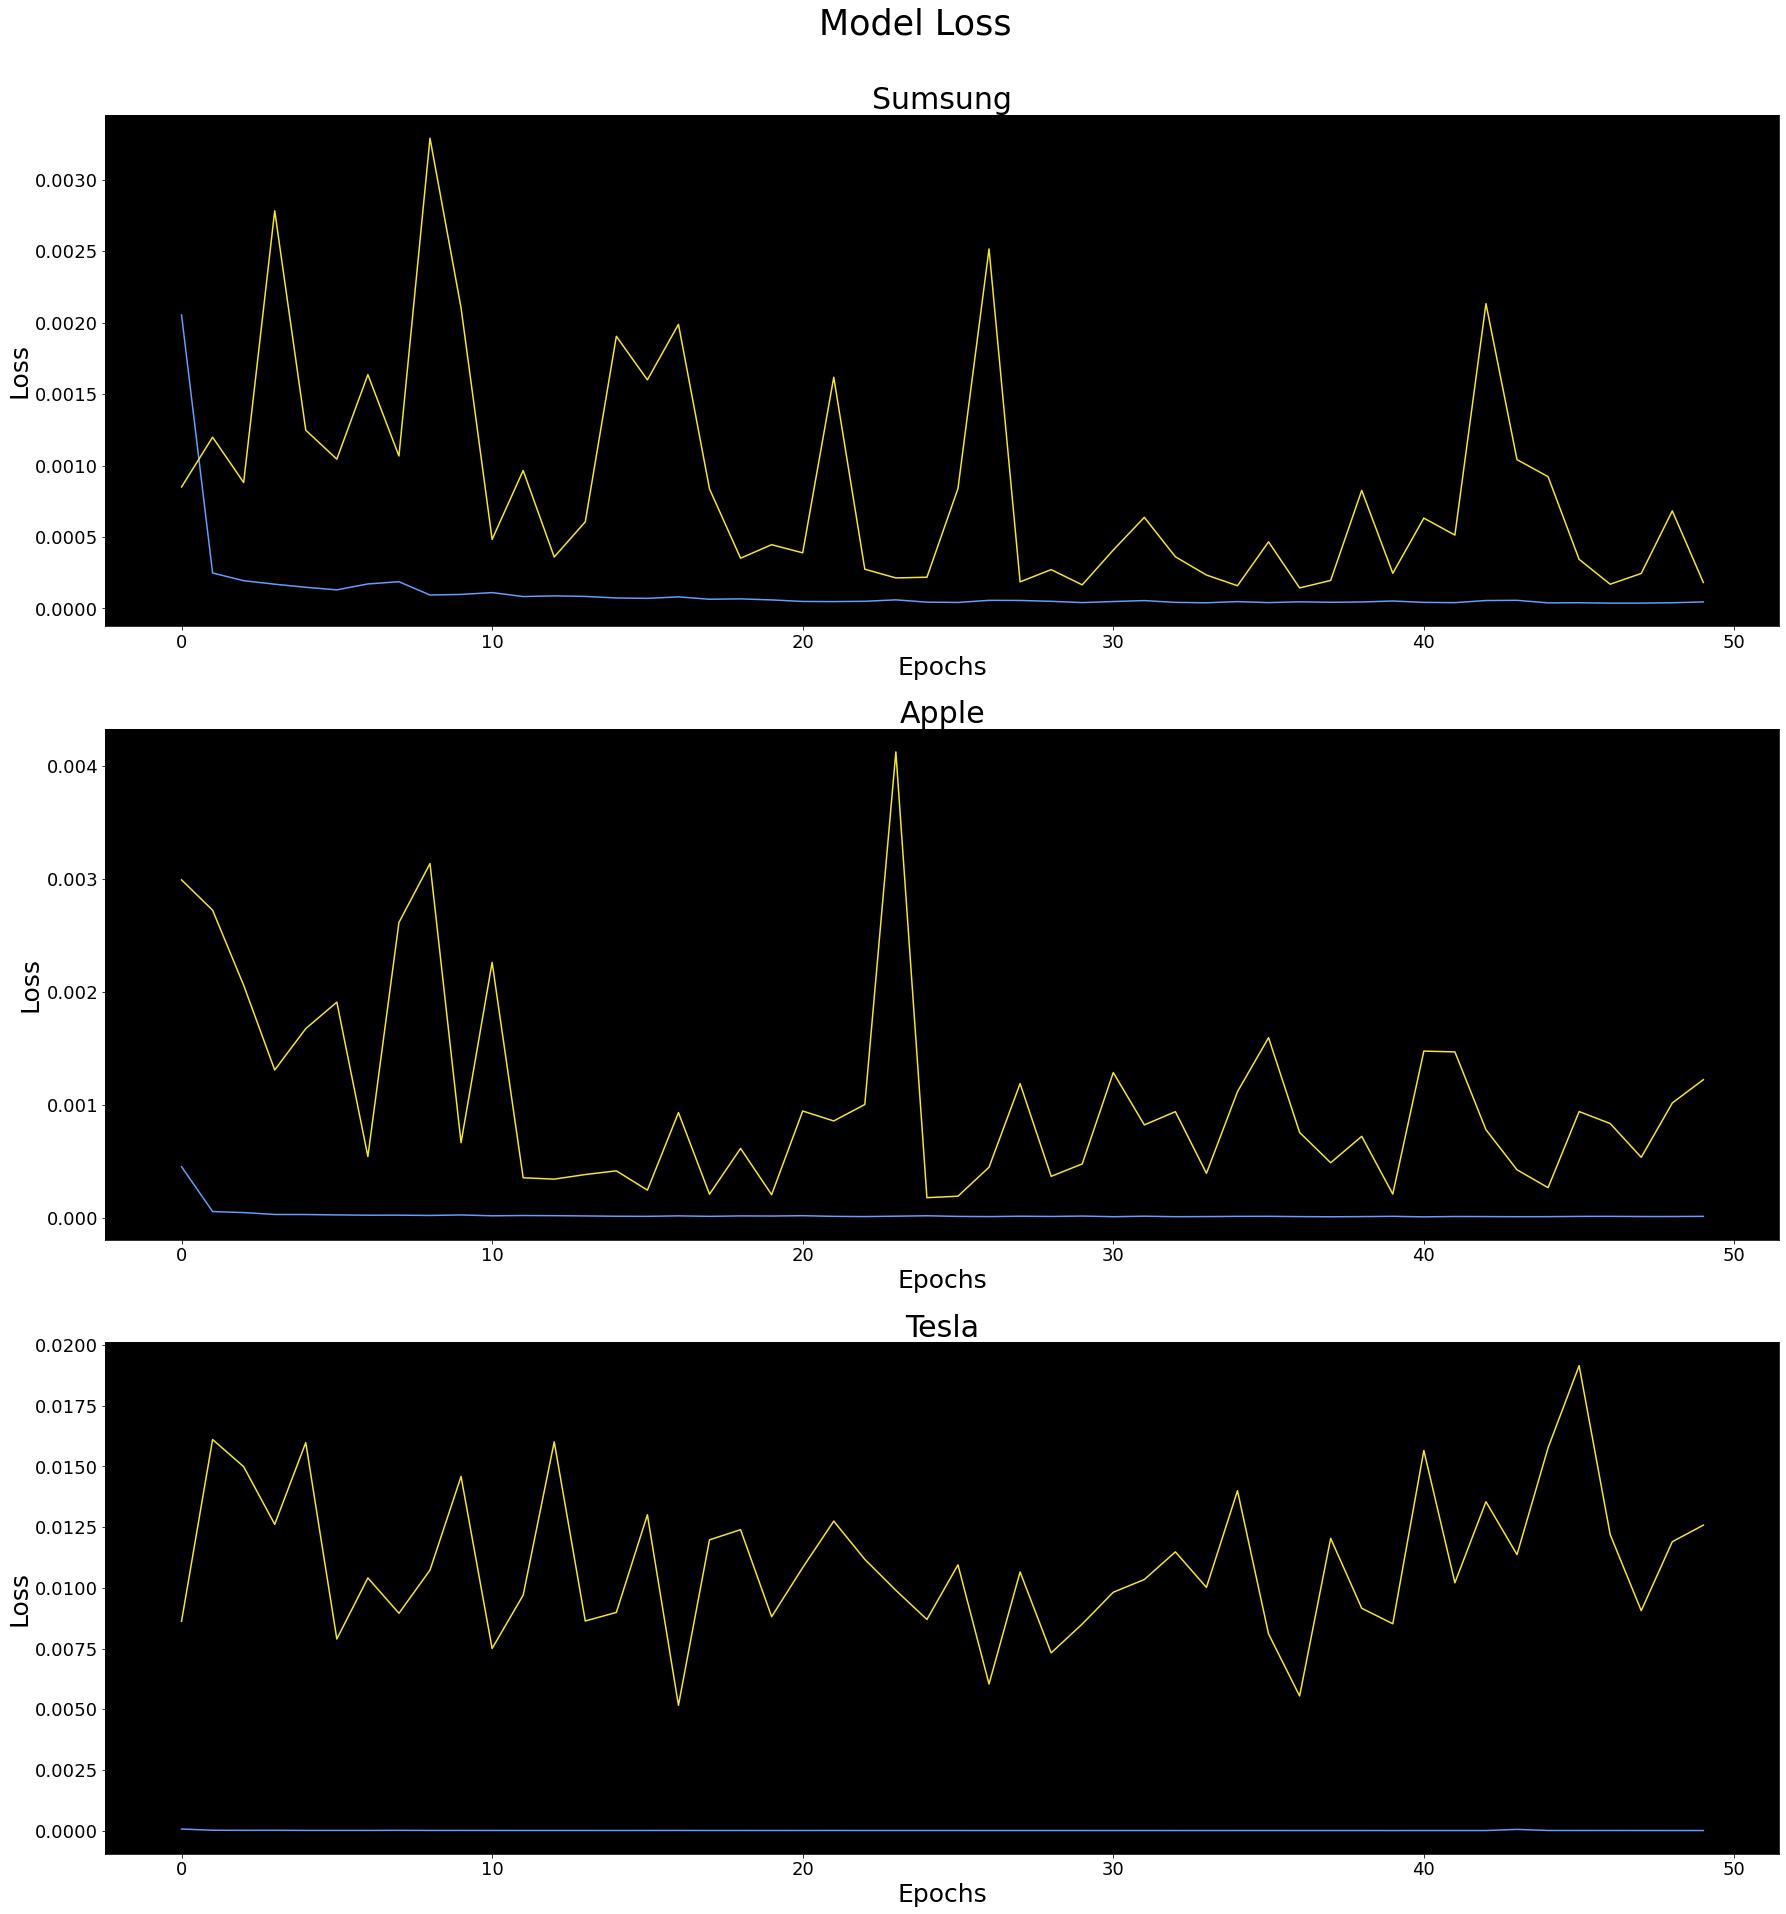

In [41]:
def visualize_model_loss(samsg_predictor,apple_predictor,tesla_predictor):
    
    fig, axes = plt.subplots(3, 1, figsize=(30, 30))
    
    plt.suptitle('Model Loss', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 35)
    
    axes[0].set_facecolor('black')
    axes[0].plot(samsg_predictor.epoch, samsg_predictor.history['loss'], label = 'loss', color = '#649EFF')
    axes[0].plot(samsg_predictor.epoch, samsg_predictor.history['val_loss'], label = 'val_loss', color = '#F5E633')
    axes[0].set_title('Sumsung', fontsize = 30)
    axes[0].set_xlabel('Epochs', fontsize = 25)
    axes[0].set_ylabel('Loss', fontsize = 25)
    axes[0].xaxis.set_tick_params(labelsize = 18)
    axes[0].yaxis.set_tick_params(labelsize = 18)
    
    axes[1].set_facecolor('black')
    axes[1].plot(apple_predictor.epoch, apple_predictor.history['loss'], label = 'loss', color = '#649EFF')
    axes[1].plot(apple_predictor.epoch, apple_predictor.history['val_loss'], label = 'val_loss', color = '#F5E633')
    axes[1].set_title('Apple', fontsize = 30)
    axes[1].set_xlabel('Epochs', fontsize = 25)
    axes[1].set_ylabel('Loss', fontsize = 25)
    axes[1].xaxis.set_tick_params(labelsize = 18)
    axes[1].yaxis.set_tick_params(labelsize = 18)
    
    axes[2].set_facecolor('black')
    axes[2].plot(tesla_predictor.epoch, tesla_predictor.history['loss'], label = 'loss', color = '#649EFF')
    axes[2].plot(tesla_predictor.epoch, tesla_predictor.history['val_loss'], label = 'val_loss', color = '#F5E633')
    axes[2].set_title('Tesla', fontsize = 30)
    axes[2].set_xlabel('Epochs', fontsize = 25)
    axes[2].set_ylabel('Loss', fontsize = 25)
    axes[2].xaxis.set_tick_params(labelsize = 18)
    axes[2].yaxis.set_tick_params(labelsize = 18)
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
visualize_model_loss(samsg_predictor,apple_predictor,tesla_predictor)

In [42]:
def predictions_inverse_scaler_rmse(company, scaler, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
    
    print(f'The RMSE for {company} is {rmse}')
    
    return y_pred, y_test

y_pred_samsg, y_test_samsg = predictions_inverse_scaler_rmse('SAMSUNG', samsg_scaler, samsg_model, X_test_samsg, y_test_samsg)
y_pred_apple, y_test_apple = predictions_inverse_scaler_rmse('APPLE', apple_scaler, apple_model, X_test_apple, y_test_apple)
y_pred_tesla, y_test_tesla = predictions_inverse_scaler_rmse('TESLA', tesla_scaler, tesla_model, X_test_tesla, y_test_tesla)

27/27 [==============================] - 0s 11ms/step
The RMSE for SAMSUNG is 1474.054876231118
27/27 [==============================] - 0s 11ms/step
The RMSE for APPLE is 9.378171596772207
26/26 [==============================] - 0s 11ms/step
The RMSE for TESLA is 64.87245272517968


In [43]:
def create_dataframes_for_plots(dataframe, y_pred):
    plot_train = dataframe[:int(np.ceil(len(dataframe) * 0.75))]
    plot_test = dataframe[int(np.ceil(len(dataframe) * 0.75)):]
    plot_test['Predictions'] = y_pred
    return plot_train, plot_test

plot_train_samsg, plot_test_samsg = create_dataframes_for_plots(samsg, y_pred_samsg)
plot_train_apple, plot_test_apple = create_dataframes_for_plots(apple, y_pred_apple)
plot_train_tesla, plot_test_tesla = create_dataframes_for_plots(tesla, y_pred_tesla)

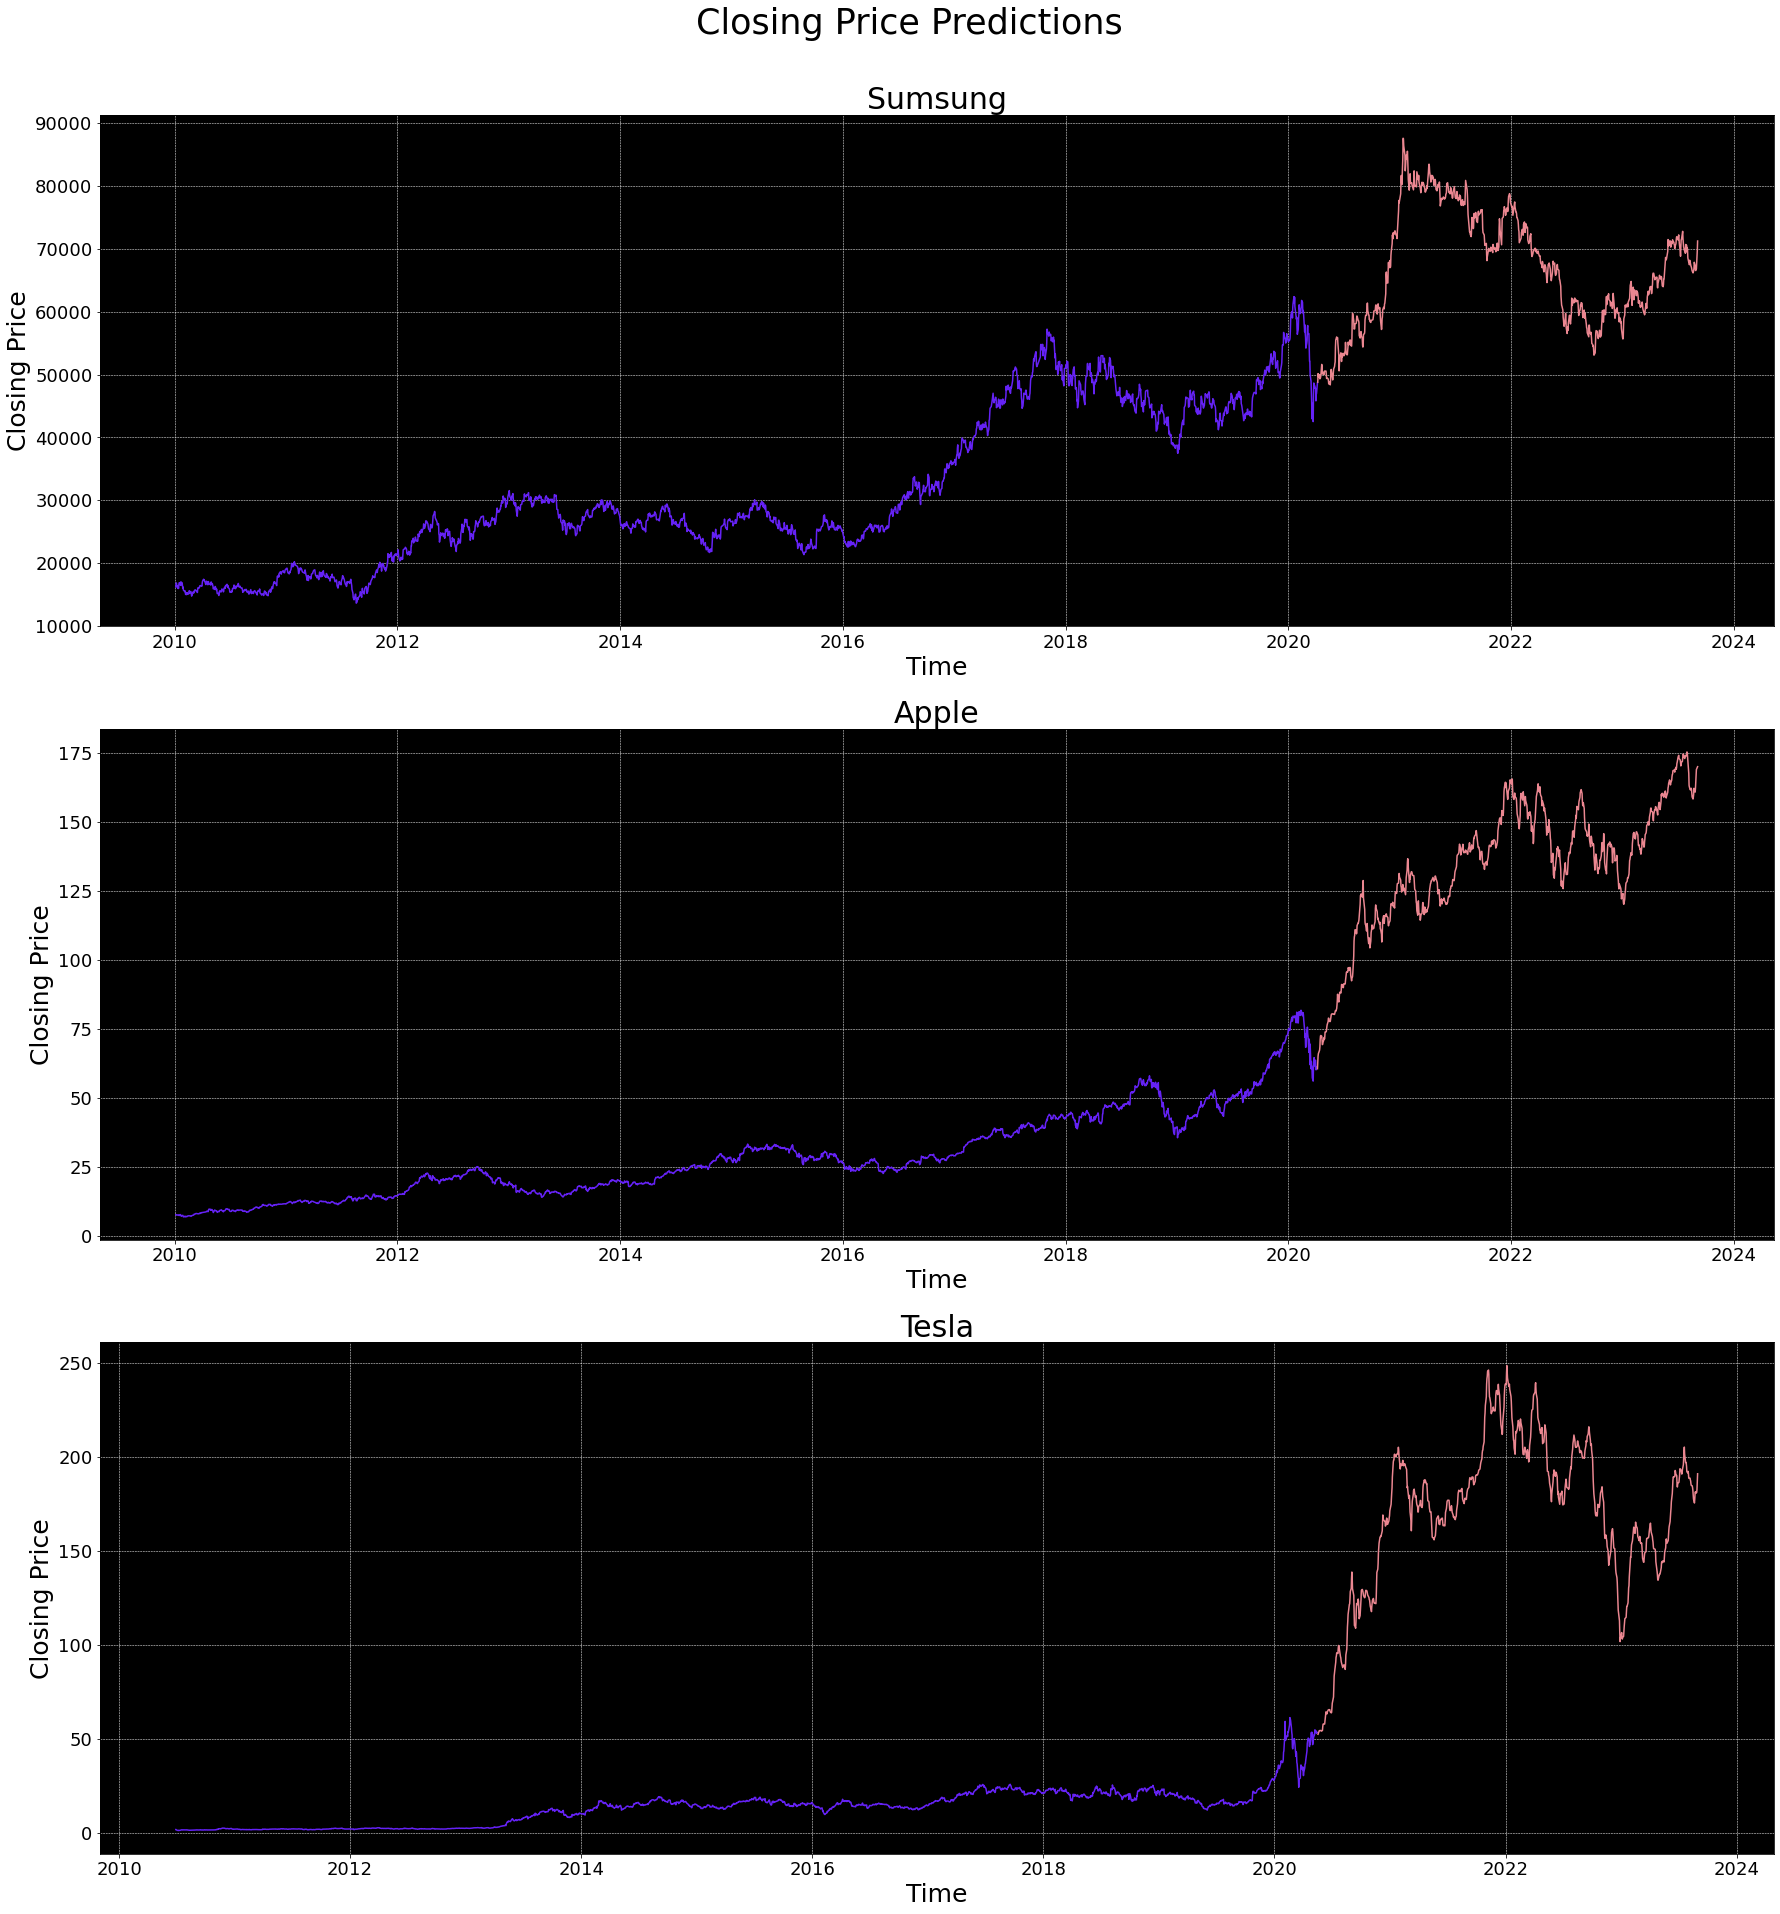

In [44]:
def plot_model_predictions(plot_train_samsg, plot_test_samsg,
                           plot_train_apple, plot_test_apple, 
                           plot_train_tesla, plot_test_tesla):
    
    fig, axes = plt.subplots(3, 1, figsize=(30, 30))
    
    plt.suptitle('Closing Price Predictions', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 35)
    
    axes[0].set_facecolor('black')
    axes[0].plot(plot_train_samsg['Date'], plot_train_samsg['Close'], color = '#6522F5', label = 'Train')
    axes[0].plot(plot_test_samsg['Date'], plot_test_samsg['Predictions'], color = '#EB8791', label = 'Predictions')
    axes[0].set_title('Sumsung', fontsize = 30)
    axes[0].set_xlabel('Time', fontsize = 25)
    axes[0].set_ylabel('Closing Price', fontsize = 25)
    axes[0].xaxis.set_tick_params(labelsize = 18)
    axes[0].yaxis.set_tick_params(labelsize = 18)
    axes[0].grid(color='white', linestyle='--', linewidth=0.5)
    
    axes[1].set_facecolor('black')
    axes[1].plot(plot_train_apple['Date'], plot_train_apple['Close'], color = '#6522F5', label = 'Train')
    axes[1].plot(plot_test_apple['Date'], plot_test_apple['Predictions'], color = '#EB8791', label = 'Predictions')
    axes[1].set_title('Apple', fontsize = 30)
    axes[1].set_xlabel('Time', fontsize = 25)
    axes[1].set_ylabel('Closing Price', fontsize = 25)
    axes[1].xaxis.set_tick_params(labelsize = 18)
    axes[1].yaxis.set_tick_params(labelsize = 18)
    axes[1].grid(color='white', linestyle='--', linewidth=0.5)
    
    axes[2].set_facecolor('black')
    axes[2].plot(plot_train_tesla['Date'], plot_train_tesla['Close'], color = '#6522F5', label = 'Train')
    axes[2].plot(plot_test_tesla['Date'], plot_test_tesla['Predictions'], color = '#EB8791', label = 'Predictions')
    axes[2].set_title('Tesla', fontsize = 30)
    axes[2].set_xlabel('Time', fontsize = 25)
    axes[2].set_ylabel('Closing Price', fontsize = 25)
    axes[2].xaxis.set_tick_params(labelsize = 18)
    axes[2].yaxis.set_tick_params(labelsize = 18)
    axes[2].grid(color='white', linestyle='--', linewidth=0.5)
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
plot_model_predictions(plot_train_samsg,
                       plot_test_samsg,plot_train_apple, plot_test_apple,
                       plot_train_tesla, plot_test_tesla)
    
